# **Import Libraries**

In [ ]:
import cv2     
import os
import math  
import matplotlib.pyplot as plt  
import seaborn as sns
from matplotlib import image as mpimg
from keras.utils.vis_utils import plot_model
import glob as gb 

%matplotlib inline
from mpl_toolkits.axes_grid1 import ImageGrid
import pandas as pd
import numpy as np
from keras.utils import np_utils
from skimage.transform import resize 

import tensorflow as tf
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy, BinaryAccuracy, TruePositives, TrueNegatives, FalsePositives, FalseNegatives

import keras
from keras import models
from keras import layers

from keras.preprocessing import image
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from keras import callbacks
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# **Preprocessing Code**

In [ ]:
from scipy.spatial import distance as dist
from imutils import face_utils
import imutils
import dlib

os.chdir('F:/Drowsiness_final')

def eye_aspect_ratio(eye):
    A = dist.euclidean(eye[1], eye[5])
    B = dist.euclidean(eye[2], eye[4])

    C = dist.euclidean(eye[0], eye[3])

    ear = (A + B) / (2.0 * C)

    return ear

def final_ear(shape):
    (lStart, lEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eye"]
    (rStart, rEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eye"]

    leftEye = shape[lStart:lEnd]
    rightEye = shape[rStart:rEnd]

    leftEAR = eye_aspect_ratio(leftEye)
    rightEAR = eye_aspect_ratio(rightEye)

    ear = (leftEAR + rightEAR) / 2.0
    return (ear, leftEye, rightEye)

def lip_distance(shape):
    top_lip = shape[50:53]
    top_lip = np.concatenate((top_lip, shape[61:64]))

    low_lip = shape[56:59]
    low_lip = np.concatenate((low_lip, shape[65:68]))

    top_mean = np.mean(top_lip, axis=0)
    low_mean = np.mean(low_lip, axis=0)

    distance = abs(top_mean[1] - low_mean[1])
    return distance

#for drowsy
EYE_AR_THRESH = 0.20
YAWN_THRESH = 22

#for not drowsy
EYE_OPEN_THRESH = 0.35

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

## **Preprocess For Trainning Data**

In [ ]:
#Data Preprocessing for training all data into diff. classes
os.chdir('F:/Drowsiness_final_final')

directory = r'C:/Users/user/Desktop/PCIU/thesis paper/Drowsiness/datasets/NTHU Dataset/Training_Evaluation_Dataset/Training Dataset'
for sub_dir_1 in os.listdir(directory):
    
    for sub_dir_2 in os.listdir(os.path.join(directory, sub_dir_1)):
        
        if str(sub_dir_2) in ['glasses', 'night_noglasses', 'nightglasses', 'noglasses', 'sunglasses']:

            for files in os.listdir(os.path.join(os.path.join(directory, sub_dir_1), sub_dir_2)):
                
                if str(files) in  ['nonsleepyCombination.avi', 'sleepyCombination.avi', 'slowBlinkWithNodding.avi', 'yawning.avi']:
                    
                    txt_file = str(directory) + '\\' + str(sub_dir_1) + '\\' + str(sub_dir_2) + '\\' + str(sub_dir_1) + '_' + str(files[:-4]) + '_drowsiness.txt'
                    file = open(txt_file, 'r') 
                    n = 0
                    temp = []
                    while True: 
                        char = file.read(1)           
                        if not char:  
                            break
                        n = n+1
                        temp.append(char)
                    #print("\n",sub_dir_2,"->",files,":->",temp,"\n")
                    if (sub_dir_2 == "glasses"):
                        if not os.path.exists('train_data/glasses'): 
                            os.makedirs('train_data/glasses/')
                        cam = cv2.VideoCapture(str(directory) + '\\' + str(sub_dir_1) + '\\' + str(sub_dir_2) + '\\' + files)
                        currentframe = 0
                        while(True): 
                            ret,frame = cam.read() 
                            
                            if ret: 
                                gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                                rects = detector(gray, 0)
                                if temp[currentframe] == '1':
                                    if not os.path.exists('train_data/glasses/drowsy'): 
                                        os.makedirs('train_data/glasses/drowsy')
                                    name = './train_data/glasses/drowsy/' + str(sub_dir_1) + '_' + str(sub_dir_2) + '_' + str(files[:-4]) + '_' +str(currentframe) + '_' + 'drowsy' + '.jpg'
                                    for rect in rects:
                                        shape = predictor(gray, rect)
                                        shape = face_utils.shape_to_np(shape)
                                        eye = final_ear(shape)
                                        ear = eye[0]
                                        distance = lip_distance(shape)
                                        if ear < EYE_AR_THRESH:
                                            (x, y, w, h) = face_utils.rect_to_bb(rect)
                                            x2, y2 = x + w, y + h
                                            x = x-10
                                            y = y-10
                                            x2 = x2+10
                                            y2 = y2+10
                                            takeFace = frame[y:y2,x:x2]
                                            print ('Creating...' + name)
                                            if takeFace.any():
                                                cv2.imwrite(name, takeFace)
                                                
                                        if (distance > YAWN_THRESH):
                                            (x, y, w, h) = face_utils.rect_to_bb(rect)
                                            x2, y2 = x + w, y + h
                                            x = x-10
                                            y = y-10
                                            x2 = x2+10
                                            y2 = y2+10
                                            takeFace = frame[y:y2,x:x2]
                                            print ('Creating...' + name)
                                            if takeFace.any():
                                                cv2.imwrite(name, takeFace)
                                                
                                if temp[currentframe] == '0':
                                    if not os.path.exists('train_data/glasses/notdrowsy'): 
                                        os.makedirs('train_data/glasses/notdrowsy')
                                    name = './train_data/glasses/notdrowsy/' + str(sub_dir_1) + '_' + str(sub_dir_2) + '_' + str(files[:-4]) + '_' +str(currentframe) + '_' + 'notdrowsy' + '.jpg'
                                    
                                    for rect in rects:
                                        shape = predictor(gray, rect)
                                        shape = face_utils.shape_to_np(shape)

                                        eye = final_ear(shape)
                                        ear = eye[0]

                                        distance = lip_distance(shape)

                                        if ear > EYE_OPEN_THRESH and distance < YAWN_THRESH:
                                            (x, y, w, h) = face_utils.rect_to_bb(rect)
                                            x2, y2 = x + w, y + h
                                            x = x-10
                                            y = y-10
                                            x2 = x2+10
                                            y2 = y2+10
                                            takeFace = frame[y:y2,x:x2]
                                            print ('Creating...' + name)
                                            if takeFace.any():
                                                cv2.imwrite(name, takeFace)
                                currentframe += 1
                            else: 
                                break
                    cam.release() 
                    cv2.destroyAllWindows() 
                    
                    
                    if (sub_dir_2 == "night_noglasses"):
                        if not os.path.exists('train_data/night_noglasses'): 
                            os.makedirs('train_data/night_noglasses/')
                        cam = cv2.VideoCapture(str(directory) + '\\' + str(sub_dir_1) + '\\' + str(sub_dir_2) + '\\' + files)
                        currentframe = 0
                        while(True): 
                            ret,frame = cam.read() 
                            if ret: 
                                gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                                rects = detector(gray, 0)
                                if temp[currentframe] == '1':
                                    if not os.path.exists('train_data/night_noglasses/drowsy'): 
                                        os.makedirs('train_data/night_noglasses/drowsy')
                                    name = './train_data/night_noglasses/drowsy/' + str(sub_dir_1) + '_' + str(sub_dir_2) + '_' + str(files[:-4]) + '_' +str(currentframe) + '_' + 'drowsy' + '.jpg'
                                    for rect in rects:
                                        shape = predictor(gray, rect)
                                        shape = face_utils.shape_to_np(shape)
                                        eye = final_ear(shape)
                                        ear = eye[0]
                                        distance = lip_distance(shape)
                                        if ear < EYE_AR_THRESH:
                                            (x, y, w, h) = face_utils.rect_to_bb(rect)
                                            x2, y2 = x + w, y + h
                                            x = x-10
                                            y = y-10
                                            x2 = x2+10
                                            y2 = y2+10
                                            takeFace = frame[y:y2,x:x2]
                                            print ('Creating...' + name)
                                            if takeFace.any():
                                                cv2.imwrite(name, takeFace)
                                                
                                        if (distance > YAWN_THRESH):
                                            (x, y, w, h) = face_utils.rect_to_bb(rect)
                                            x2, y2 = x + w, y + h
                                            x = x-10
                                            y = y-10
                                            x2 = x2+10
                                            y2 = y2+10
                                            takeFace = frame[y:y2,x:x2]
                                            print ('Creating...' + name)
                                            if takeFace.any():
                                                cv2.imwrite(name, takeFace)
                                if temp[currentframe] == '0':
                                    if not os.path.exists('train_data/night_noglasses/notdrowsy'): 
                                        os.makedirs('train_data/night_noglasses/notdrowsy')
                                    name = './train_data/night_noglasses/notdrowsy/' + str(sub_dir_1) + '_' + str(sub_dir_2) + '_' + str(files[:-4]) + '_' +str(currentframe) + '_' + 'notdrowsy' + '.jpg'
                                    for rect in rects:
                                        shape = predictor(gray, rect)
                                        shape = face_utils.shape_to_np(shape)

                                        eye = final_ear(shape)
                                        ear = eye[0]

                                        distance = lip_distance(shape)

                                        if ear > EYE_OPEN_THRESH and distance < YAWN_THRESH:
                                            (x, y, w, h) = face_utils.rect_to_bb(rect)
                                            x2, y2 = x + w, y + h
                                            x = x-10
                                            y = y-10
                                            x2 = x2+10
                                            y2 = y2+10
                                            takeFace = frame[y:y2,x:x2]
                                            print ('Creating...' + name)
                                            if takeFace.any():
                                                cv2.imwrite(name, takeFace)
                                currentframe += 1
                            else: 
                                break
                    cam.release() 
                    cv2.destroyAllWindows() 
                    
                    
                    if (sub_dir_2 == "nightglasses"):
                        if not os.path.exists('train_data/nightglasses'): 
                            os.makedirs('train_data/nightglasses/')
                        cam = cv2.VideoCapture(str(directory) + '\\' + str(sub_dir_1) + '\\' + str(sub_dir_2) + '\\' + files)
                        currentframe = 0
                        while(True): 
                            ret,frame = cam.read() 
                            if ret: 
                                gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                                rects = detector(gray, 0)
                                if temp[currentframe] == '1':
                                    if not os.path.exists('train_data/nightglasses/drowsy'): 
                                        os.makedirs('train_data/nightglasses/drowsy')
                                    name = './train_data/nightglasses/drowsy/' + str(sub_dir_1) + '_' + str(sub_dir_2) + '_' + str(files[:-4]) + '_' +str(currentframe) + '_' + 'drowsy' + '.jpg'
                                    for rect in rects:
                                        shape = predictor(gray, rect)
                                        shape = face_utils.shape_to_np(shape)
                                        eye = final_ear(shape)
                                        ear = eye[0]
                                        distance = lip_distance(shape)
                                        if ear < EYE_AR_THRESH:
                                            (x, y, w, h) = face_utils.rect_to_bb(rect)
                                            x2, y2 = x + w, y + h
                                            x = x-10
                                            y = y-10
                                            x2 = x2+10
                                            y2 = y2+10
                                            takeFace = frame[y:y2,x:x2]
                                            print ('Creating...' + name)
                                            if takeFace.any():
                                                cv2.imwrite(name, takeFace)
                                                
                                        if (distance > YAWN_THRESH):
                                            (x, y, w, h) = face_utils.rect_to_bb(rect)
                                            x2, y2 = x + w, y + h
                                            x = x-10
                                            y = y-10
                                            x2 = x2+10
                                            y2 = y2+10
                                            takeFace = frame[y:y2,x:x2]
                                            print ('Creating...' + name)
                                            if takeFace.any():
                                                cv2.imwrite(name, takeFace)
                                if temp[currentframe] == '0':
                                    if not os.path.exists('train_data/nightglasses/notdrowsy'): 
                                        os.makedirs('train_data/nightglasses/notdrowsy')
                                    name = './train_data/nightglasses/notdrowsy/' + str(sub_dir_1) + '_' + str(sub_dir_2) + '_' + str(files[:-4]) + '_' +str(currentframe) + '_' + 'notdrowsy' + '.jpg'
                                    for rect in rects:
                                        shape = predictor(gray, rect)
                                        shape = face_utils.shape_to_np(shape)

                                        eye = final_ear(shape)
                                        ear = eye[0]

                                        distance = lip_distance(shape)

                                        if ear > EYE_OPEN_THRESH and distance < YAWN_THRESH:
                                            (x, y, w, h) = face_utils.rect_to_bb(rect)
                                            x2, y2 = x + w, y + h
                                            x = x-10
                                            y = y-10
                                            x2 = x2+10
                                            y2 = y2+10
                                            takeFace = frame[y:y2,x:x2]
                                            print ('Creating...' + name)
                                            if takeFace.any():
                                                cv2.imwrite(name, takeFace)
                                currentframe += 1
                            else: 
                                break
                    cam.release() 
                    cv2.destroyAllWindows() 
                    
                    
                    if (sub_dir_2 == "noglasses"):
                        if not os.path.exists('train_data/noglasses'): 
                            os.makedirs('train_data/noglasses/')
                        cam = cv2.VideoCapture(str(directory) + '\\' + str(sub_dir_1) + '\\' + str(sub_dir_2) + '\\' + files)
                        currentframe = 0
                        while(True): 
                            ret,frame = cam.read() 
                            if ret: 
                                gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                                rects = detector(gray, 0)
                                if temp[currentframe] == '1':
                                    if not os.path.exists('train_data/noglasses/drowsy'): 
                                        os.makedirs('train_data/noglasses/drowsy')
                                    name = './train_data/noglasses/drowsy/' + str(sub_dir_1) + '_' + str(sub_dir_2) + '_' + str(files[:-4]) + '_' +str(currentframe) + '_' + 'drowsy' + '.jpg'
                                    for rect in rects:
                                        shape = predictor(gray, rect)
                                        shape = face_utils.shape_to_np(shape)
                                        eye = final_ear(shape)
                                        ear = eye[0]
                                        distance = lip_distance(shape)
                                        if ear < EYE_AR_THRESH:
                                            (x, y, w, h) = face_utils.rect_to_bb(rect)
                                            x2, y2 = x + w, y + h
                                            x = x-10
                                            y = y-10
                                            x2 = x2+10
                                            y2 = y2+10
                                            takeFace = frame[y:y2,x:x2]
                                            print ('Creating...' + name)
                                            if takeFace.any():
                                                cv2.imwrite(name, takeFace)
                                                
                                        if (distance > YAWN_THRESH):
                                            (x, y, w, h) = face_utils.rect_to_bb(rect)
                                            x2, y2 = x + w, y + h
                                            x = x-10
                                            y = y-10
                                            x2 = x2+10
                                            y2 = y2+10
                                            takeFace = frame[y:y2,x:x2]
                                            print ('Creating...' + name)
                                            if takeFace.any():
                                                cv2.imwrite(name, takeFace)
                                if temp[currentframe] == '0':
                                    if not os.path.exists('train_data/noglasses/notdrowsy'): 
                                        os.makedirs('train_data/noglasses/notdrowsy')
                                    name = './train_data/noglasses/notdrowsy/' + str(sub_dir_1) + '_' + str(sub_dir_2) + '_' + str(files[:-4]) + '_' +str(currentframe) + '_' + 'notdrowsy' + '.jpg'
                                    for rect in rects:
                                        shape = predictor(gray, rect)
                                        shape = face_utils.shape_to_np(shape)

                                        eye = final_ear(shape)
                                        ear = eye[0]

                                        distance = lip_distance(shape)

                                        if ear > EYE_OPEN_THRESH and distance < YAWN_THRESH:
                                            (x, y, w, h) = face_utils.rect_to_bb(rect)
                                            x2, y2 = x + w, y + h
                                            x = x-10
                                            y = y-10
                                            x2 = x2+10
                                            y2 = y2+10
                                            takeFace = frame[y:y2,x:x2]
                                            print ('Creating...' + name)
                                            if takeFace.any():
                                                cv2.imwrite(name, takeFace)
                                currentframe += 1
                            else: 
                                break
                    cam.release() 
                    cv2.destroyAllWindows() 
                    
                    if (sub_dir_2 == "sunglasses"):
                        if not os.path.exists('train_data/sunglasses'): 
                            os.makedirs('train_data/sunglasses/')
                        cam = cv2.VideoCapture(str(directory) + '\\' + str(sub_dir_1) + '\\' + str(sub_dir_2) + '\\' + files)
                        currentframe = 0
                        while(True): 
                            ret,frame = cam.read() 
                            if ret: 
                                gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                                rects = detector(gray, 0)
                                if temp[currentframe] == '1':
                                    if not os.path.exists('train_data/sunglasses/drowsy'): 
                                        os.makedirs('train_data/sunglasses/drowsy')
                                    name = './train_data/sunglasses/drowsy/' + str(sub_dir_1) + '_' + str(sub_dir_2) + '_' + str(files[:-4]) + '_' +str(currentframe) + '_' + 'drowsy' + '.jpg'
                                    for rect in rects:
                                        shape = predictor(gray, rect)
                                        shape = face_utils.shape_to_np(shape)
                                        eye = final_ear(shape)
                                        ear = eye[0]
                                        distance = lip_distance(shape)
                                        if ear < EYE_AR_THRESH:
                                            (x, y, w, h) = face_utils.rect_to_bb(rect)
                                            x2, y2 = x + w, y + h
                                            x = x-10
                                            y = y-10
                                            x2 = x2+10
                                            y2 = y2+10
                                            takeFace = frame[y:y2,x:x2]
                                            print ('Creating...' + name)
                                            if takeFace.any():
                                                cv2.imwrite(name, takeFace)
                                                
                                        if (distance > YAWN_THRESH):
                                            (x, y, w, h) = face_utils.rect_to_bb(rect)
                                            x2, y2 = x + w, y + h
                                            x = x-10
                                            y = y-10
                                            x2 = x2+10
                                            y2 = y2+10
                                            takeFace = frame[y:y2,x:x2]
                                            print ('Creating...' + name)
                                            if takeFace.any():
                                                cv2.imwrite(name, takeFace)
                                if temp[currentframe] == '0':
                                    if not os.path.exists('train_data/sunglasses/notdrowsy'): 
                                        os.makedirs('train_data/sunglasses/notdrowsy')
                                    name = './train_data/sunglasses/notdrowsy/' + str(sub_dir_1) + '_' + str(sub_dir_2) + '_' + str(files[:-4]) + '_' +str(currentframe) + '_' + 'notdrowsy' + '.jpg'
                                    for rect in rects:
                                        shape = predictor(gray, rect)
                                        shape = face_utils.shape_to_np(shape)

                                        eye = final_ear(shape)
                                        ear = eye[0]

                                        distance = lip_distance(shape)

                                        if ear > EYE_OPEN_THRESH and distance < YAWN_THRESH:
                                            (x, y, w, h) = face_utils.rect_to_bb(rect)
                                            x2, y2 = x + w, y + h
                                            x = x-10
                                            y = y-10
                                            x2 = x2+10
                                            y2 = y2+10
                                            takeFace = frame[y:y2,x:x2]
                                            print ('Creating...' + name)
                                            if takeFace.any():
                                                cv2.imwrite(name, takeFace)
                                currentframe += 1
                            else: 
                                break
                    cam.release() 
                    cv2.destroyAllWindows()
                    
                    file.close()

## **Preprocessing For Test Data**

In [ ]:
os.chdir('F:/Drowsiness_final_final')
directory = r'C:/Users/user/Desktop/PCIU/thesis paper/Drowsiness/datasets/NTHU Dataset/Training_Evaluation_Dataset/Evaluation Dataset'
for sub_dir_1 in os.listdir(directory):

    for files in os.listdir(os.path.join(directory, sub_dir_1)):
        
        if str(files) in  [sub_dir_1+'_'+'glasses_mix.mp4', sub_dir_1+'_'+'nightglasses_mix.mp4', 
                           sub_dir_1+'_'+'night_noglasses_mix.mp4', sub_dir_1+'_'+'noglasses_mix.mp4', sub_dir_1+'_'+'sunglasses_mix.mp4']:

            txt_file = str(directory) + '\\' + str(sub_dir_1) + '\\' + str(files[:-4]) + 'ing_drowsiness.txt'
            folderName = str(files[4:-8])
            file = open(txt_file, 'r') 
            n = 0
            temp = []
            while True: 
                char = file.read(1)           
                if not char:  
                    break
                n = n+1
                temp.append(char)
            if (folderName == "glasses"):
                if not os.path.exists('val_data/glasses'): 
                    os.makedirs('val_data/glasses/')
                cam = cv2.VideoCapture(str(directory) + '\\' + str(sub_dir_1) + '\\' + files) 
                currentframe = 0
                while(True): 
                    ret,frame = cam.read() 
                    if ret: 
                        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                        rects = detector(gray, 0)
                        if temp[currentframe] == '1':
                            if not os.path.exists('val_data/glasses/drowsy'): 
                                os.makedirs('val_data/glasses/drowsy')
                            name = './val_data/glasses/drowsy/' + str(sub_dir_1) + '_' + str(files[:-4]) + '_' +str(currentframe) + '_' + 'drowsy' + '.jpg'
                            for rect in rects:
                                shape = predictor(gray, rect)
                                shape = face_utils.shape_to_np(shape)
                                eye = final_ear(shape)
                                ear = eye[0]
                                distance = lip_distance(shape)
                                if ear < EYE_AR_THRESH:
                                    (x, y, w, h) = face_utils.rect_to_bb(rect)
                                    x2, y2 = x + w, y + h
                                    x = x-10
                                    y = y-10
                                    x2 = x2+10
                                    y2 = y2+10
                                    takeFace = frame[y:y2,x:x2]
                                    print ('Creating...' + name)
                                    if takeFace.any():
                                        cv2.imwrite(name, takeFace)

                                if (distance > YAWN_THRESH):
                                    (x, y, w, h) = face_utils.rect_to_bb(rect)
                                    x2, y2 = x + w, y + h
                                    x = x-10
                                    y = y-10
                                    x2 = x2+10
                                    y2 = y2+10
                                    takeFace = frame[y:y2,x:x2]
                                    print ('Creating...' + name)
                                    if takeFace.any():
                                        cv2.imwrite(name, takeFace)
                        if temp[currentframe] == '0':
                            if not os.path.exists('val_data/glasses/notdrowsy'): 
                                os.makedirs('val_data/glasses/notdrowsy')
                            name = './val_data/glasses/notdrowsy/' + str(sub_dir_1) + '_' + str(files[:-4]) + '_' +str(currentframe) + '_' + 'notdrowsy' + '.jpg'
                            for rect in rects:
                                shape = predictor(gray, rect)
                                shape = face_utils.shape_to_np(shape)

                                eye = final_ear(shape)
                                ear = eye[0]

                                distance = lip_distance(shape)

                                if ear > EYE_OPEN_THRESH and distance < YAWN_THRESH:
                                    (x, y, w, h) = face_utils.rect_to_bb(rect)
                                    x2, y2 = x + w, y + h
                                    x = x-10
                                    y = y-10
                                    x2 = x2+10
                                    y2 = y2+10
                                    takeFace = frame[y:y2,x:x2]
                                    print ('Creating...' + name)
                                    if takeFace.any():
                                        cv2.imwrite(name, takeFace)
                        currentframe += 1
                    else: 
                        break
            cam.release() 
            cv2.destroyAllWindows() 


            if (folderName == "night_noglasses"):
                if not os.path.exists('val_data/night_noglasses'): 
                    os.makedirs('val_data/night_noglasses/')
                cam = cv2.VideoCapture(str(directory) + '\\' + str(sub_dir_1) + '\\' + files)
                currentframe = 0
                while(True): 
                    ret,frame = cam.read() 
                    if ret: 
                        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                        rects = detector(gray, 0)
                        if temp[currentframe] == '1':
                            if not os.path.exists('val_data/night_noglasses/drowsy'): 
                                os.makedirs('val_data/night_noglasses/drowsy')
                            name = './val_data/night_noglasses/drowsy/' + str(sub_dir_1) + '_' + str(files[:-4]) + '_' +str(currentframe) + '_' + 'drowsy' + '.jpg'
                            for rect in rects:
                                shape = predictor(gray, rect)
                                shape = face_utils.shape_to_np(shape)
                                eye = final_ear(shape)
                                ear = eye[0]
                                distance = lip_distance(shape)
                                if ear < EYE_AR_THRESH:
                                    (x, y, w, h) = face_utils.rect_to_bb(rect)
                                    x2, y2 = x + w, y + h
                                    x = x-10
                                    y = y-10
                                    x2 = x2+10
                                    y2 = y2+10
                                    takeFace = frame[y:y2,x:x2]
                                    print ('Creating...' + name)
                                    if takeFace.any():
                                        cv2.imwrite(name, takeFace)

                                if (distance > YAWN_THRESH):
                                    (x, y, w, h) = face_utils.rect_to_bb(rect)
                                    x2, y2 = x + w, y + h
                                    x = x-10
                                    y = y-10
                                    x2 = x2+10
                                    y2 = y2+10
                                    takeFace = frame[y:y2,x:x2]
                                    print ('Creating...' + name)
                                    if takeFace.any():
                                        cv2.imwrite(name, takeFace)
                        if temp[currentframe] == '0':
                            if not os.path.exists('val_data/night_noglasses/notdrowsy'): 
                                os.makedirs('val_data/night_noglasses/notdrowsy')
                            name = './val_data/night_noglasses/notdrowsy/' + str(sub_dir_1) + '_' + str(files[:-4]) + '_' +str(currentframe) + '_' + 'notdrowsy' + '.jpg'
                            for rect in rects:
                                shape = predictor(gray, rect)
                                shape = face_utils.shape_to_np(shape)

                                eye = final_ear(shape)
                                ear = eye[0]

                                distance = lip_distance(shape)

                                if ear > EYE_OPEN_THRESH and distance < YAWN_THRESH:
                                    (x, y, w, h) = face_utils.rect_to_bb(rect)
                                    x2, y2 = x + w, y + h
                                    x = x-10
                                    y = y-10
                                    x2 = x2+10
                                    y2 = y2+10
                                    takeFace = frame[y:y2,x:x2]
                                    print ('Creating...' + name)
                                    if takeFace.any():
                                        cv2.imwrite(name, takeFace)
                        currentframe += 1
                    else: 
                        break
            cam.release() 
            cv2.destroyAllWindows() 


            if (folderName == "nightglasses"):
                if not os.path.exists('val_data/nightglasses'): 
                    os.makedirs('val_data/nightglasses/')
                cam = cv2.VideoCapture(str(directory) + '\\' + str(sub_dir_1) + '\\' + files) 
                currentframe = 0
                while(True): 
                    ret,frame = cam.read() 
                    if ret: 
                        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                        rects = detector(gray, 0)
                        if temp[currentframe] == '1':
                            if not os.path.exists('val_data/nightglasses/drowsy'): 
                                os.makedirs('val_data/nightglasses/drowsy')
                            name = './val_data/nightglasses/drowsy/' + str(sub_dir_1) + '_' + str(files[:-4]) + '_' +str(currentframe) + '_' + 'drowsy' + '.jpg'
                            for rect in rects:
                                shape = predictor(gray, rect)
                                shape = face_utils.shape_to_np(shape)
                                eye = final_ear(shape)
                                ear = eye[0]
                                distance = lip_distance(shape)
                                if ear < EYE_AR_THRESH:
                                    (x, y, w, h) = face_utils.rect_to_bb(rect)
                                    x2, y2 = x + w, y + h
                                    x = x-10
                                    y = y-10
                                    x2 = x2+10
                                    y2 = y2+10
                                    takeFace = frame[y:y2,x:x2]
                                    print ('Creating...' + name)
                                    if takeFace.any():
                                        cv2.imwrite(name, takeFace)

                                if (distance > YAWN_THRESH):
                                    (x, y, w, h) = face_utils.rect_to_bb(rect)
                                    x2, y2 = x + w, y + h
                                    x = x-10
                                    y = y-10
                                    x2 = x2+10
                                    y2 = y2+10
                                    takeFace = frame[y:y2,x:x2]
                                    print ('Creating...' + name)
                                    if takeFace.any():
                                        cv2.imwrite(name, takeFace)
                        if temp[currentframe] == '0':
                            if not os.path.exists('val_data/nightglasses/notdrowsy'): 
                                os.makedirs('val_data/nightglasses/notdrowsy')
                            name = './val_data/nightglasses/notdrowsy/' + str(sub_dir_1) + '_' + str(files[:-4]) + '_' +str(currentframe) + '_' + 'notdrowsy' + '.jpg'
                            for rect in rects:
                                shape = predictor(gray, rect)
                                shape = face_utils.shape_to_np(shape)

                                eye = final_ear(shape)
                                ear = eye[0]

                                distance = lip_distance(shape)

                                if ear > EYE_OPEN_THRESH and distance < YAWN_THRESH:
                                    (x, y, w, h) = face_utils.rect_to_bb(rect)
                                    x2, y2 = x + w, y + h
                                    x = x-10
                                    y = y-10
                                    x2 = x2+10
                                    y2 = y2+10
                                    takeFace = frame[y:y2,x:x2]
                                    print ('Creating...' + name)
                                    if takeFace.any():
                                        cv2.imwrite(name, takeFace)
                        currentframe += 1
                    else: 
                        break
            cam.release() 
            cv2.destroyAllWindows() 


            if (folderName == "noglasses"):
                if not os.path.exists('val_data/noglasses'): 
                    os.makedirs('val_data/noglasses/')
                cam = cv2.VideoCapture(str(directory) + '\\' + str(sub_dir_1) + '\\' + files) 
                currentframe = 0
                while(True): 
                    ret,frame = cam.read() 
                    if ret: 
                        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                        rects = detector(gray, 0)
                        if temp[currentframe] == '1':
                            if not os.path.exists('val_data/noglasses/drowsy'): 
                                os.makedirs('val_data/noglasses/drowsy')
                            name = './val_data/noglasses/drowsy/' + str(sub_dir_1) + '_' + str(files[:-4]) + '_' +str(currentframe) + '_' + 'drowsy' + '.jpg'
                            for rect in rects:
                                shape = predictor(gray, rect)
                                shape = face_utils.shape_to_np(shape)
                                eye = final_ear(shape)
                                ear = eye[0]
                                distance = lip_distance(shape)
                                if ear < EYE_AR_THRESH:
                                    (x, y, w, h) = face_utils.rect_to_bb(rect)
                                    x2, y2 = x + w, y + h
                                    x = x-10
                                    y = y-10
                                    x2 = x2+10
                                    y2 = y2+10
                                    takeFace = frame[y:y2,x:x2]
                                    print ('Creating...' + name)
                                    if takeFace.any():
                                        cv2.imwrite(name, takeFace)

                                if (distance > YAWN_THRESH):
                                    (x, y, w, h) = face_utils.rect_to_bb(rect)
                                    x2, y2 = x + w, y + h
                                    x = x-10
                                    y = y-10
                                    x2 = x2+10
                                    y2 = y2+10
                                    takeFace = frame[y:y2,x:x2]
                                    print ('Creating...' + name)
                                    if takeFace.any():
                                        cv2.imwrite(name, takeFace)
                        if temp[currentframe] == '0':
                            if not os.path.exists('val_data/noglasses/notdrowsy'): 
                                os.makedirs('val_data/noglasses/notdrowsy')
                            name = './val_data/noglasses/notdrowsy/' + str(sub_dir_1) + '_' + str(files[:-4]) + '_' +str(currentframe) + '_' + 'notdrowsy' + '.jpg'
                            for rect in rects:
                                shape = predictor(gray, rect)
                                shape = face_utils.shape_to_np(shape)

                                eye = final_ear(shape)
                                ear = eye[0]

                                distance = lip_distance(shape)

                                if ear > EYE_OPEN_THRESH and distance < YAWN_THRESH:
                                    (x, y, w, h) = face_utils.rect_to_bb(rect)
                                    x2, y2 = x + w, y + h
                                    x = x-10
                                    y = y-10
                                    x2 = x2+10
                                    y2 = y2+10
                                    takeFace = frame[y:y2,x:x2]
                                    print ('Creating...' + name)
                                    if takeFace.any():
                                        cv2.imwrite(name, takeFace)
                        currentframe += 1
                    else: 
                        break
            cam.release() 
            cv2.destroyAllWindows() 

            if (folderName == "sunglasses"):
                if not os.path.exists('val_data/sunglasses'): 
                    os.makedirs('val_data/sunglasses/')
                cam = cv2.VideoCapture(str(directory) + '\\' + str(sub_dir_1) + '\\' + files) 
                currentframe = 0
                while(True): 
                    ret,frame = cam.read() 
                    if ret: 
                        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                        rects = detector(gray, 0)
                        if temp[currentframe] == '1':
                            if not os.path.exists('val_data/sunglasses/drowsy'): 
                                os.makedirs('val_data/sunglasses/drowsy')
                            name = './val_data/sunglasses/drowsy/' + str(sub_dir_1) + '_' + str(files[:-4]) + '_' +str(currentframe) + '_' + 'drowsy' + '.jpg'
                            for rect in rects:
                                shape = predictor(gray, rect)
                                shape = face_utils.shape_to_np(shape)
                                eye = final_ear(shape)
                                ear = eye[0]
                                distance = lip_distance(shape)
                                if ear < EYE_AR_THRESH:
                                    (x, y, w, h) = face_utils.rect_to_bb(rect)
                                    x2, y2 = x + w, y + h
                                    x = x-10
                                    y = y-10
                                    x2 = x2+10
                                    y2 = y2+10
                                    takeFace = frame[y:y2,x:x2]
                                    print ('Creating...' + name)
                                    if takeFace.any():
                                        cv2.imwrite(name, takeFace)

                                if (distance > YAWN_THRESH):
                                    (x, y, w, h) = face_utils.rect_to_bb(rect)
                                    x2, y2 = x + w, y + h
                                    x = x-10
                                    y = y-10
                                    x2 = x2+10
                                    y2 = y2+10
                                    takeFace = frame[y:y2,x:x2]
                                    print ('Creating...' + name)
                                    if takeFace.any():
                                        cv2.imwrite(name, takeFace)
                        if temp[currentframe] == '0':
                            if not os.path.exists('val_data/sunglasses/notdrowsy'): 
                                os.makedirs('val_data/sunglasses/notdrowsy')
                            name = './val_data/sunglasses/notdrowsy/' + str(sub_dir_1) + '_' + str(files[:-4]) + '_' +str(currentframe) + '_' + 'notdrowsy' + '.jpg'
                            for rect in rects:
                                shape = predictor(gray, rect)
                                shape = face_utils.shape_to_np(shape)

                                eye = final_ear(shape)
                                ear = eye[0]

                                distance = lip_distance(shape)

                                if ear > EYE_OPEN_THRESH and distance < YAWN_THRESH:
                                    (x, y, w, h) = face_utils.rect_to_bb(rect)
                                    x2, y2 = x + w, y + h
                                    x = x-10
                                    y = y-10
                                    x2 = x2+10
                                    y2 = y2+10
                                    takeFace = frame[y:y2,x:x2]
                                    print ('Creating...' + name)
                                    if takeFace.any():
                                        cv2.imwrite(name, takeFace)
                        currentframe += 1
                    else: 
                        break
            cam.release() 
            cv2.destroyAllWindows()

            file.close()

## **Data upzip from drive**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip gdrive/My\ Drive/Dataset/Merged/train.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/notdrowsy/036_night_noglasses_nonsleepyCombination_1264_notdrowsy.jpg  
  inflating: train/notdrowsy/036_night_noglasses_nonsleepyCombination_127_notdrowsy.jpg  
  inflating: train/notdrowsy/036_night_noglasses_nonsleepyCombination_128_notdrowsy.jpg  
  inflating: train/notdrowsy/036_night_noglasses_nonsleepyCombination_129_notdrowsy.jpg  
  inflating: train/notdrowsy/036_night_noglasses_nonsleepyCombination_13_notdrowsy.jpg  
  inflating: train/notdrowsy/036_night_noglasses_nonsleepyCombination_130_notdrowsy.jpg  
  inflating: train/notdrowsy/036_night_noglasses_nonsleepyCombination_131_notdrowsy.jpg  
  inflating: train/notdrowsy/036_night_noglasses_nonsleepyCombination_132_notdrowsy.jpg  
  inflating: train/notdrowsy/036_night_noglasses_nonsleepyCombination_133_notdrowsy.jpg  
  inflating: train/notdrowsy/036_night_noglasses_nonsleepyCombination_134_notdrowsy.jpg  
  inflating: train/notdrowsy/036_night_noglasses_

In [ ]:
!unzip gdrive/My\ Drive/Dataset/Merged/val.zip

Streaming output truncated to the last 5000 lines.
  inflating: val/notdrowsy/030_030_night_noglasses_mix_117_notdrowsy.jpg  
  inflating: val/notdrowsy/030_030_night_noglasses_mix_118_notdrowsy.jpg  
  inflating: val/notdrowsy/030_030_night_noglasses_mix_119_notdrowsy.jpg  
  inflating: val/notdrowsy/030_030_night_noglasses_mix_12_notdrowsy.jpg  
  inflating: val/notdrowsy/030_030_night_noglasses_mix_120_notdrowsy.jpg  
  inflating: val/notdrowsy/030_030_night_noglasses_mix_121_notdrowsy.jpg  
  inflating: val/notdrowsy/030_030_night_noglasses_mix_122_notdrowsy.jpg  
  inflating: val/notdrowsy/030_030_night_noglasses_mix_123_notdrowsy.jpg  
  inflating: val/notdrowsy/030_030_night_noglasses_mix_124_notdrowsy.jpg  
  inflating: val/notdrowsy/030_030_night_noglasses_mix_125_notdrowsy.jpg  
  inflating: val/notdrowsy/030_030_night_noglasses_mix_126_notdrowsy.jpg  
  inflating: val/notdrowsy/030_030_night_noglasses_mix_127_notdrowsy.jpg  
  inflating: val/notdrowsy/030_030_night_noglasses

In [ ]:
!unzip gdrive/My\ Drive/Dataset/train_data.zip

Streaming output truncated to the last 5000 lines.
  inflating: train_data/sunglasses/notdrowsy/012_sunglasses_yawning_368_notdrowsy.jpg  
  inflating: train_data/sunglasses/notdrowsy/012_sunglasses_yawning_369_notdrowsy.jpg  
  inflating: train_data/sunglasses/notdrowsy/012_sunglasses_yawning_370_notdrowsy.jpg  
  inflating: train_data/sunglasses/notdrowsy/012_sunglasses_yawning_371_notdrowsy.jpg  
  inflating: train_data/sunglasses/notdrowsy/012_sunglasses_yawning_372_notdrowsy.jpg  
  inflating: train_data/sunglasses/notdrowsy/012_sunglasses_yawning_373_notdrowsy.jpg  
  inflating: train_data/sunglasses/notdrowsy/012_sunglasses_yawning_374_notdrowsy.jpg  
  inflating: train_data/sunglasses/notdrowsy/012_sunglasses_yawning_375_notdrowsy.jpg  
  inflating: train_data/sunglasses/notdrowsy/012_sunglasses_yawning_376_notdrowsy.jpg  
  inflating: train_data/sunglasses/notdrowsy/012_sunglasses_yawning_377_notdrowsy.jpg  
  inflating: train_data/sunglasses/notdrowsy/012_sunglasses_yawning_3

In [ ]:
!unzip gdrive/My\ Drive/Dataset/val_data.zip

Streaming output truncated to the last 5000 lines.
  inflating: val_data/sunglasses/drowsy/004_004_sunglasses_mix_1254_drowsy.jpg  
  inflating: val_data/sunglasses/drowsy/004_004_sunglasses_mix_1256_drowsy.jpg  
  inflating: val_data/sunglasses/drowsy/004_004_sunglasses_mix_1262_drowsy.jpg  
  inflating: val_data/sunglasses/drowsy/004_004_sunglasses_mix_1263_drowsy.jpg  
  inflating: val_data/sunglasses/drowsy/004_004_sunglasses_mix_1264_drowsy.jpg  
  inflating: val_data/sunglasses/drowsy/004_004_sunglasses_mix_1278_drowsy.jpg  
  inflating: val_data/sunglasses/drowsy/004_004_sunglasses_mix_1279_drowsy.jpg  
  inflating: val_data/sunglasses/drowsy/004_004_sunglasses_mix_1280_drowsy.jpg  
  inflating: val_data/sunglasses/drowsy/004_004_sunglasses_mix_1287_drowsy.jpg  
  inflating: val_data/sunglasses/drowsy/004_004_sunglasses_mix_1288_drowsy.jpg  
  inflating: val_data/sunglasses/drowsy/004_004_sunglasses_mix_1289_drowsy.jpg  
  inflating: val_data/sunglasses/drowsy/004_004_sunglasses

# **Load Data**

Found 194150 files belonging to 2 classes.
Found 34423 files belonging to 2 classes.


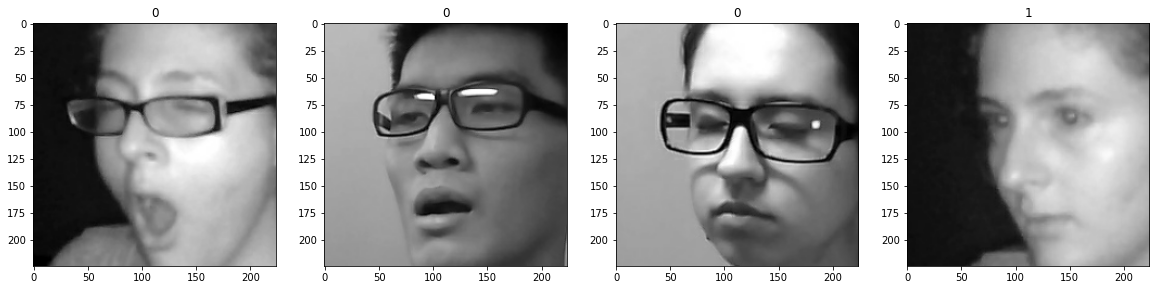

In [ ]:
train_data = tf.keras.utils.image_dataset_from_directory('train',image_size=(224, 224))
test_data = tf.keras.utils.image_dataset_from_directory('val',image_size=(224, 224))
train_data_iterator = train_data.as_numpy_iterator()
train_batch = train_data_iterator.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(train_batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(train_batch[1][idx])
# 0 = Drowsy
# 1 = Not Drowsy

# **CNN Model**

## **Data Augmentaion And Train Test Split**

In [ ]:
#augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1./255)

batchs = 32

train_generator=train_datagen.flow_from_directory(
    #directory='train_data/noglasses',
    #directory='train_data/glasses',
    #directory='train_data/nightglasses',
    #directory='train_data/night_noglasses',
    directory='train_data/sunglasses',
    #directory='train',
    target_size=(224, 224),
    batch_size=batchs,
    class_mode="binary",
    shuffle=True
)

valid_generator=test_datagen.flow_from_directory(
    #directory='val_data/noglasses',
    #directory='val_data/glasses',
    #directory='val_data/nightglasses',
    #directory='val_data/night_noglasses',
    directory='val_data/sunglasses',
    #directory='val', 
    target_size=(224, 224),
    batch_size=batchs,
    class_mode="binary",
    shuffle=True
)


Found 38024 images belonging to 2 classes.
Found 5168 images belonging to 2 classes.


## **Build Model**

In [ ]:
#nightglasses
cnn3 = models.Sequential()
cnn3.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224,224,3)))
cnn3.add(layers.MaxPooling2D((2, 2)))

cnn3.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn3.add(layers.MaxPooling2D((2, 2)))

cnn3.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn3.add(layers.MaxPooling2D((2, 2)))

cnn3.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn3.add(layers.MaxPooling2D((2, 2)))

cnn3.add(layers.Dropout(0.20))
cnn3.add(layers.Flatten())

cnn3.add(layers.Dense(512, activation='relu', kernel_regularizer=l2(0.01)))
cnn3.add(layers.Dropout(0.15))
cnn3.add(layers.Dense(1, activation='sigmoid'))
cnn3.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)     

In [ ]:
#noglasses
cnn4 = models.Sequential()
cnn4.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224,224,3)))
cnn4.add(layers.MaxPooling2D((2, 2)))

cnn4.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn4.add(layers.MaxPooling2D((2, 2)))

cnn4.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn4.add(layers.MaxPooling2D((2, 2)))

cnn4.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn4.add(layers.MaxPooling2D((2, 2)))

cnn4.add(layers.Dropout(0.20))
cnn4.add(layers.Flatten())

cnn4.add(layers.Dense(512, activation='relu', kernel_regularizer=l2(0.01)))
cnn4.add(layers.Dropout(0.15))
cnn4.add(layers.Dense(1, activation='sigmoid'))
cnn4.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_41 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_41 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_42 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 26, 26, 128)    

In [ ]:
#glasses
cnn5 = models.Sequential()
cnn5.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224,224,3)))
cnn5.add(layers.MaxPooling2D((2, 2)))

cnn5.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn5.add(layers.MaxPooling2D((2, 2)))

cnn5.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn5.add(layers.MaxPooling2D((2, 2)))

cnn5.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn5.add(layers.MaxPooling2D((2, 2)))

cnn5.add(layers.Dropout(0.20))
cnn5.add(layers.Flatten())

cnn5.add(layers.Dense(512, activation='relu', kernel_regularizer=l2(0.01)))
cnn5.add(layers.Dropout(0.15))
cnn5.add(layers.Dense(1, activation='sigmoid'))
cnn5.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_44 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_44 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_45 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_46 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_46 (MaxPoolin  (None, 26, 26, 128)    

In [ ]:
#Night No Glasses
cnn6 = models.Sequential()
cnn6.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224,224,3)))
cnn6.add(layers.MaxPooling2D((2, 2)))

cnn6.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn6.add(layers.MaxPooling2D((2, 2)))

cnn6.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn6.add(layers.MaxPooling2D((2, 2)))

cnn6.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn6.add(layers.MaxPooling2D((2, 2)))

cnn6.add(layers.Dropout(0.20))
cnn6.add(layers.Flatten())

cnn6.add(layers.Dense(512, activation='relu', kernel_regularizer=l2(0.01)))
cnn6.add(layers.Dropout(0.15))
cnn6.add(layers.Dense(1, activation='sigmoid'))
cnn6.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_52 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_52 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_53 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_53 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_54 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_54 (MaxPoolin  (None, 26, 26, 128)    

In [ ]:
#sunglasses
cnn7 = models.Sequential()
cnn7.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224,224,3)))
cnn7.add(layers.MaxPooling2D((2, 2)))

cnn7.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn7.add(layers.MaxPooling2D((2, 2)))

cnn7.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn7.add(layers.MaxPooling2D((2, 2)))

cnn7.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn7.add(layers.MaxPooling2D((2, 2)))

cnn7.add(layers.Dropout(0.20))
cnn7.add(layers.Flatten())

cnn7.add(layers.Dense(512, activation='relu', kernel_regularizer=l2(0.01)))
cnn7.add(layers.Dropout(0.15))
cnn7.add(layers.Dense(1, activation='sigmoid'))
cnn7.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 26, 26, 128)     

In [ ]:
#with all marged data
cnn8 = models.Sequential()
cnn8.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224,224,3)))
cnn8.add(layers.MaxPooling2D((2, 2)))

cnn8.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn8.add(layers.MaxPooling2D((2, 2)))

cnn8.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn8.add(layers.MaxPooling2D((2, 2)))

cnn8.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn8.add(layers.MaxPooling2D((2, 2)))

cnn8.add(layers.Dropout(0.20))
cnn8.add(layers.Flatten())

cnn8.add(layers.Dense(512, activation='relu', kernel_regularizer=l2(0.01)))
cnn8.add(layers.Dropout(0.15))
cnn8.add(layers.Dense(1, activation='sigmoid'))
cnn8.summary()

In [ ]:
#with all marged data refined
cnn8 = models.Sequential()
cnn8.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224,224,3)))
cnn8.add(layers.MaxPooling2D((2, 2)))

cnn8.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn8.add(layers.MaxPooling2D((2, 2)))

cnn8.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)))
cnn8.add(layers.MaxPooling2D((2, 2)))

cnn8.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn8.add(layers.MaxPooling2D((2, 2)))

cnn8.add(layers.Dropout(0.20))
cnn8.add(layers.Flatten())

cnn8.add(layers.Dense(512, activation='relu', kernel_regularizer=l2(0.01)))
cnn8.add(layers.Dropout(0.15))
cnn8.add(layers.Dense(1, activation='sigmoid'))
cnn8.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 26, 26, 128)     

In [ ]:
#nightglasses
cnn3.compile(optimizer='Adam',
             loss='binary_crossentropy',
             metrics=['accuracy']
             )

In [ ]:
#noglasses
cnn4.compile(optimizer='Adam',
             loss='binary_crossentropy',
             metrics=['accuracy']
             )

In [ ]:
#glasses
cnn5.compile(optimizer='Adam',
             loss='binary_crossentropy',
             metrics=['accuracy']
             )

In [ ]:
#Night No Glasses
cnn6.compile(optimizer='Adam',
             loss='binary_crossentropy',
             metrics=['accuracy']
             )

In [ ]:
#sunglasses
cnn7.compile(optimizer='Adam',
             loss='binary_crossentropy',
             metrics=['accuracy']
             )

In [ ]:
#with all merged data
cnn8.compile(optimizer='Adam',
             loss='binary_crossentropy',
             metrics=['accuracy']
             )

## **Train The Model**

In [ ]:
#nightglasses
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(filepath='nightglasses.h5', verbose=1, save_best_only=True)
callbacks_ = [checkpoint]

history=cnn3.fit(train_generator,
                          steps_per_epoch= (train_generator.samples)/train_generator.batch_size,
                          epochs=10, 
                          verbose=1,
                          validation_data=valid_generator,
                          validation_steps = (valid_generator.samples)/valid_generator.batch_size,
                          #callbacks=callbacks_,
               )

Epoch 1/10
649/649 [==============================] - 210s 323ms/step - loss: 0.7480 - accuracy: 0.7008 - val_loss: 0.8100 - val_accuracy: 0.6200
Epoch 2/10
649/649 [==============================] - 209s 322ms/step - loss: 0.4390 - accuracy: 0.8430 - val_loss: 0.7686 - val_accuracy: 0.6244
Epoch 3/10
649/649 [==============================] - 209s 322ms/step - loss: 0.3430 - accuracy: 0.8967 - val_loss: 0.5750 - val_accuracy: 0.8016
Epoch 4/10
649/649 [==============================] - 208s 321ms/step - loss: 0.2929 - accuracy: 0.9208 - val_loss: 0.5598 - val_accuracy: 0.7602
Epoch 5/10
649/649 [==============================] - 209s 321ms/step - loss: 0.2691 - accuracy: 0.9340 - val_loss: 0.4378 - val_accuracy: 0.8482
Epoch 6/10
649/649 [==============================] - 209s 321ms/step - loss: 0.2460 - accuracy: 0.9412 - val_loss: 0.4508 - val_accuracy: 0.8090
Epoch 7/10
649/649 [==============================] - 208s 320ms/step - loss: 0.2399 - accuracy: 0.9436 - val_loss: 0.4097 -

In [ ]:
#nightglasses refined
history=cnn3.fit(train_generator,
                          steps_per_epoch= (train_generator.samples)/train_generator.batch_size,
                          epochs=10, 
                          verbose=1,
                          validation_data=valid_generator,
                          validation_steps = (valid_generator.samples)/valid_generator.batch_size,
               )

Epoch 1/10
649/649 [==============================] - 212s 326ms/step - loss: 0.7126 - accuracy: 0.7349 - val_loss: 0.6620 - val_accuracy: 0.7018
Epoch 2/10
649/649 [==============================] - 211s 325ms/step - loss: 0.4475 - accuracy: 0.8522 - val_loss: 0.6456 - val_accuracy: 0.7119
Epoch 3/10
649/649 [==============================] - 210s 324ms/step - loss: 0.3465 - accuracy: 0.9018 - val_loss: 0.5950 - val_accuracy: 0.7575
Epoch 4/10
649/649 [==============================] - 210s 324ms/step - loss: 0.2838 - accuracy: 0.9260 - val_loss: 0.6036 - val_accuracy: 0.7971
Epoch 5/10
649/649 [==============================] - 211s 325ms/step - loss: 0.2434 - accuracy: 0.9423 - val_loss: 0.4288 - val_accuracy: 0.8502
Epoch 6/10
649/649 [==============================] - 210s 323ms/step - loss: 0.2153 - accuracy: 0.9499 - val_loss: 0.4302 - val_accuracy: 0.8555
Epoch 7/10
649/649 [==============================] - 210s 323ms/step - loss: 0.2078 - accuracy: 0.9550 - val_loss: 0.2930 -

In [ ]:
#noglasses
history_2=cnn4.fit(train_generator,
                          steps_per_epoch= (train_generator.samples)/train_generator.batch_size,
                          epochs=10, 
                          verbose=1,
                          validation_data=valid_generator,
                          validation_steps = (valid_generator.samples)/valid_generator.batch_size,
               )

Epoch 1/10
1654/1654 [==============================] - 516s 312ms/step - loss: 0.3275 - accuracy: 0.9238 - val_loss: 0.4865 - val_accuracy: 0.8233
Epoch 2/10
1654/1654 [==============================] - 515s 311ms/step - loss: 0.1593 - accuracy: 0.9704 - val_loss: 0.6655 - val_accuracy: 0.7640
Epoch 3/10
1654/1654 [==============================] - 515s 312ms/step - loss: 0.1251 - accuracy: 0.9778 - val_loss: 0.1936 - val_accuracy: 0.9350
Epoch 4/10
1654/1654 [==============================] - 516s 312ms/step - loss: 0.1160 - accuracy: 0.9797 - val_loss: 0.1901 - val_accuracy: 0.9423
Epoch 5/10
1654/1654 [==============================] - 515s 311ms/step - loss: 0.1012 - accuracy: 0.9829 - val_loss: 0.1126 - val_accuracy: 0.9877
Epoch 6/10
1654/1654 [==============================] - 515s 311ms/step - loss: 0.0965 - accuracy: 0.9838 - val_loss: 0.2489 - val_accuracy: 0.8958
Epoch 7/10
1654/1654 [==============================] - 514s 311ms/step - loss: 0.0895 - accuracy: 0.9856 - val_

In [ ]:
#glasses
history_3=cnn5.fit(train_generator,
                          steps_per_epoch= (train_generator.samples)/train_generator.batch_size,
                          epochs=10, 
                          verbose=1,
                          validation_data=valid_generator,
                          validation_steps = (valid_generator.samples)/valid_generator.batch_size,
               )

Epoch 1/10
1401/1401 [==============================] - 451s 322ms/step - loss: 0.3735 - accuracy: 0.9052 - val_loss: 0.2705 - val_accuracy: 0.9349
Epoch 2/10
1401/1401 [==============================] - 444s 317ms/step - loss: 0.1926 - accuracy: 0.9583 - val_loss: 0.1980 - val_accuracy: 0.9593
Epoch 3/10
1401/1401 [==============================] - 441s 315ms/step - loss: 0.1516 - accuracy: 0.9702 - val_loss: 0.2785 - val_accuracy: 0.9219
Epoch 4/10
1401/1401 [==============================] - 440s 314ms/step - loss: 0.1366 - accuracy: 0.9736 - val_loss: 0.2457 - val_accuracy: 0.9431
Epoch 5/10
1401/1401 [==============================] - 441s 315ms/step - loss: 0.1244 - accuracy: 0.9769 - val_loss: 0.2215 - val_accuracy: 0.9206
Epoch 6/10
1401/1401 [==============================] - 442s 316ms/step - loss: 0.1133 - accuracy: 0.9792 - val_loss: 0.1296 - val_accuracy: 0.9767
Epoch 7/10
1401/1401 [==============================] - 441s 315ms/step - loss: 0.1029 - accuracy: 0.9818 - val_

In [ ]:
#Night No Glasses
history_4=cnn6.fit(train_generator,
                          steps_per_epoch= (train_generator.samples)/train_generator.batch_size,
                          epochs=10, 
                          verbose=1,
                          validation_data=valid_generator,
                          validation_steps = (valid_generator.samples)/valid_generator.batch_size,
               )

Epoch 1/10
1174/1174 [==============================] - 375s 319ms/step - loss: 0.4812 - accuracy: 0.8406 - val_loss: 0.1766 - val_accuracy: 0.9629
Epoch 2/10
1174/1174 [==============================] - 373s 318ms/step - loss: 0.2164 - accuracy: 0.9513 - val_loss: 0.1928 - val_accuracy: 0.9538
Epoch 3/10
1174/1174 [==============================] - 373s 318ms/step - loss: 0.1775 - accuracy: 0.9646 - val_loss: 0.1742 - val_accuracy: 0.9603
Epoch 4/10
1174/1174 [==============================] - 374s 319ms/step - loss: 0.1591 - accuracy: 0.9693 - val_loss: 0.2567 - val_accuracy: 0.9231
Epoch 5/10
1174/1174 [==============================] - 373s 318ms/step - loss: 0.1481 - accuracy: 0.9728 - val_loss: 0.2117 - val_accuracy: 0.9471
Epoch 6/10
1174/1174 [==============================] - 375s 319ms/step - loss: 0.1405 - accuracy: 0.9731 - val_loss: 0.2243 - val_accuracy: 0.9360
Epoch 7/10
1174/1174 [==============================] - 374s 319ms/step - loss: 0.1310 - accuracy: 0.9759 - val_

In [ ]:
#sunglasses
history_5=cnn7.fit(train_generator,
                          steps_per_epoch= (train_generator.samples)/train_generator.batch_size,
                          epochs=10, 
                          verbose=1,
                          validation_data=valid_generator,
                          validation_steps = (valid_generator.samples)/valid_generator.batch_size,
               )

Epoch 1/10
1188/1188 [==============================] - 425s 357ms/step - loss: 0.5830 - accuracy: 0.8466 - val_loss: 0.7564 - val_accuracy: 0.6426
Epoch 2/10
1188/1188 [==============================] - 425s 357ms/step - loss: 0.4327 - accuracy: 0.8980 - val_loss: 0.6282 - val_accuracy: 0.7560
Epoch 3/10
1188/1188 [==============================] - 424s 357ms/step - loss: 0.3871 - accuracy: 0.9140 - val_loss: 0.6993 - val_accuracy: 0.6372
Epoch 4/10
1188/1188 [==============================] - 426s 359ms/step - loss: 0.3670 - accuracy: 0.9211 - val_loss: 0.8070 - val_accuracy: 0.6774
Epoch 5/10
1188/1188 [==============================] - 424s 357ms/step - loss: 0.3440 - accuracy: 0.9290 - val_loss: 0.6898 - val_accuracy: 0.7562
Epoch 6/10
1188/1188 [==============================] - 424s 357ms/step - loss: 0.3432 - accuracy: 0.9301 - val_loss: 0.8120 - val_accuracy: 0.7357
Epoch 7/10
1188/1188 [==============================] - 425s 358ms/step - loss: 0.3317 - accuracy: 0.9325 - val_

In [ ]:
#with all merged data
history_6=cnn8.fit(train_generator,
                          steps_per_epoch= (train_generator.samples)/train_generator.batch_size,
                          epochs=12, 
                          verbose=1,
                          validation_data=valid_generator,
                          validation_steps = (valid_generator.samples)/valid_generator.batch_size,
               )

Epoch 1/12
6067/6067 [==============================] - 2045s 337ms/step - loss: 0.3274 - accuracy: 0.8980 - val_loss: 0.3558 - val_accuracy: 0.8992
Epoch 2/12
6067/6067 [==============================] - 1932s 318ms/step - loss: 0.1883 - accuracy: 0.9518 - val_loss: 0.3030 - val_accuracy: 0.8977
Epoch 3/12
6067/6067 [==============================] - 2115s 349ms/step - loss: 0.1610 - accuracy: 0.9592 - val_loss: 0.3326 - val_accuracy: 0.8776
Epoch 4/12
6067/6067 [==============================] - 2185s 360ms/step - loss: 0.1431 - accuracy: 0.9641 - val_loss: 0.3062 - val_accuracy: 0.9197
Epoch 5/12
6067/6067 [==============================] - 2016s 332ms/step - loss: 0.1330 - accuracy: 0.9679 - val_loss: 0.2991 - val_accuracy: 0.9028
Epoch 6/12
6067/6067 [==============================] - 1939s 320ms/step - loss: 0.1247 - accuracy: 0.9702 - val_loss: 0.4183 - val_accuracy: 0.8649
Epoch 7/12
6067/6067 [==============================] - 1940s 320ms/step - loss: 0.1170 - accuracy: 0.9728

In [ ]:
#with all merged data refined
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(filepath='MyCNN.h5', verbose=1, save_best_only=True)
callbacks_ = [checkpoint]

history_6=cnn8.fit(train_generator,
                          steps_per_epoch= (train_generator.samples)/train_generator.batch_size,
                          epochs=20, 
                          verbose=1,
                          validation_data=valid_generator,
                          validation_steps = (valid_generator.samples)/valid_generator.batch_size,
                          callbacks = callbacks_,
               )

Epoch 1/20
6068/6067 [==============================] - ETA: 0s - loss: 0.3626 - accuracy: 0.8962
Epoch 1: val_loss improved from inf to 0.43776, saving model to MyCNN.h5
6067/6067 [==============================] - 2023s 333ms/step - loss: 0.3626 - accuracy: 0.8962 - val_loss: 0.4378 - val_accuracy: 0.8855
Epoch 2/20
6068/6067 [==============================] - ETA: 0s - loss: 0.2214 - accuracy: 0.9492
Epoch 2: val_loss improved from 0.43776 to 0.42704, saving model to MyCNN.h5
6067/6067 [==============================] - 1984s 327ms/step - loss: 0.2214 - accuracy: 0.9492 - val_loss: 0.4270 - val_accuracy: 0.8834
Epoch 3/20
6068/6067 [==============================] - ETA: 0s - loss: 0.1962 - accuracy: 0.9568
Epoch 3: val_loss did not improve from 0.42704
6067/6067 [==============================] - 1967s 324ms/step - loss: 0.1962 - accuracy: 0.9568 - val_loss: 0.5004 - val_accuracy: 0.8679
Epoch 4/20
6068/6067 [==============================] - ETA: 0s - loss: 0.1853 - accuracy: 0.96

In [ ]:
#nightglasses
cnn3.save('/content/drive/MyDrive/Dataset/nightglasses.h5')

In [ ]:
#noglasses
cnn4.save('/content/drive/MyDrive/Dataset/noglasses.h5')

In [ ]:
#glasses
cnn5.save('/content/drive/MyDrive/Dataset/glasses.h5')

In [ ]:
#Night No Glasses
cnn6.save('/content/drive/MyDrive/Dataset/night_noglasses.h5')

In [ ]:
#sunglasses
cnn7.save('/content/gdrive/MyDrive/Dataset/sunglasses.h5')

In [ ]:
#with all merged data
cnn8.save('/content/drive/MyDrive/Dataset/full_model.h5')

## **Plot Performance**

### **NightGlasses**

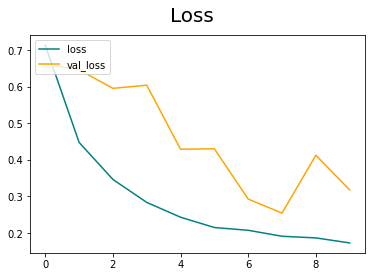

In [ ]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

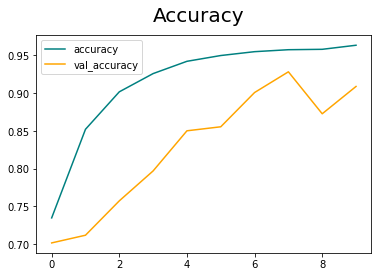

In [ ]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

### **NoGlasses**

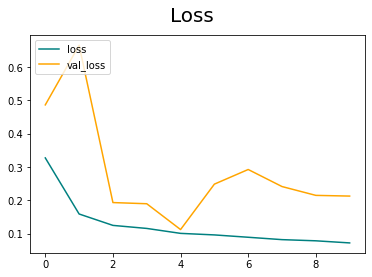

In [ ]:
fig = plt.figure()
plt.plot(history_2.history['loss'], color='teal', label='loss')
plt.plot(history_2.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

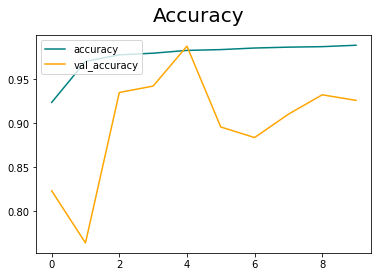

In [ ]:
fig = plt.figure()
plt.plot(history_2.history['accuracy'], color='teal', label='accuracy')
plt.plot(history_2.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

### **Glasses**

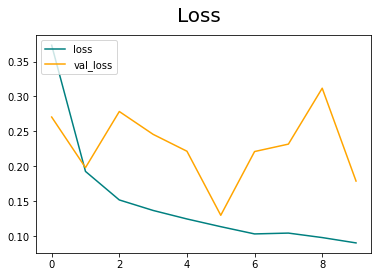

In [ ]:
fig = plt.figure()
plt.plot(history_3.history['loss'], color='teal', label='loss')
plt.plot(history_3.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

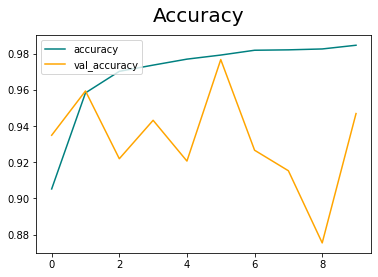

In [ ]:
fig = plt.figure()
plt.plot(history_3.history['accuracy'], color='teal', label='accuracy')
plt.plot(history_3.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

### **Night_NoGlasses**

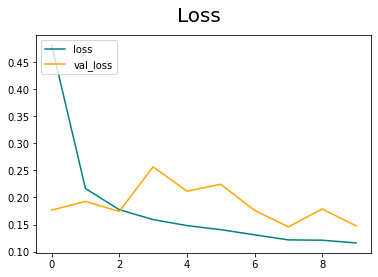

In [ ]:
fig = plt.figure()
plt.plot(history_4.history['loss'], color='teal', label='loss')
plt.plot(history_4.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

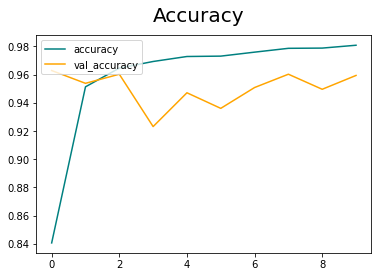

In [ ]:
fig = plt.figure()
plt.plot(history_4.history['accuracy'], color='teal', label='accuracy')
plt.plot(history_4.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

### **SunGlasses**

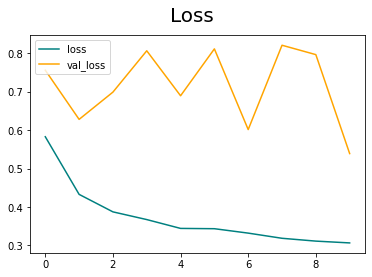

In [ ]:
fig = plt.figure()
plt.plot(history_5.history['loss'], color='teal', label='loss')
plt.plot(history_5.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

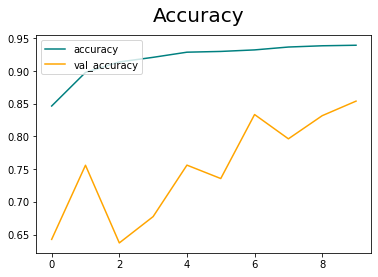

In [ ]:
fig = plt.figure()
plt.plot(history_5.history['accuracy'], color='teal', label='accuracy')
plt.plot(history_5.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

### **With All Merged Data**

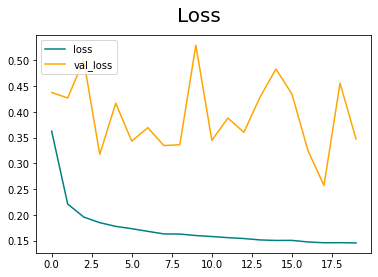

In [ ]:
fig = plt.figure()
plt.plot(history_6.history['loss'], color='teal', label='loss')
plt.plot(history_6.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

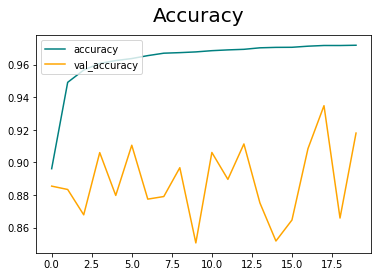

In [ ]:
fig = plt.figure()
plt.plot(history_6.history['accuracy'], color='teal', label='accuracy')
plt.plot(history_6.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

## **Confusion Matrix**

### **NightGlasses**

In [ ]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

TP = TruePositives()
TN = TrueNegatives()
FP = FalsePositives()
FN = FalseNegatives()

In [ ]:
test_data = tf.keras.utils.image_dataset_from_directory('val_data/nightglasses',image_size=(224, 224))

Found 6964 files belonging to 2 classes.


In [ ]:
test_data = test_data.map(lambda x,y: (x/255, y))
for batch in test_data.as_numpy_iterator(): 
    X, y = batch
    yhat = cnn3.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)
    TP.update_state(y, yhat)
    TN.update_state(y, yhat)
    FP.update_state(y, yhat)
    FN.update_state(y, yhat)

In [ ]:
F1Measure = 2*((pre.result().numpy()*re.result().numpy())/(pre.result().numpy()+re.result().numpy()))
F1Measure = "{:.8f}".format(F1Measure)

print("Precesion   : ", pre.result().numpy())
print("Recall      : ", re.result().numpy())
print("Accuracy    : ", acc.result().numpy())
print("F1-Measure  : ", F1Measure)


print("True Positive   : ", TP.result().numpy())
print("True Negative   : ", TN.result().numpy())
print("False Positive  : ", FP.result().numpy())
print("False Negative  : ", FN.result().numpy())

Precesion   :  0.9830156
Recall      :  0.8346086
Accuracy    :  0.912414
F1-Measure  :  0.90275347
True Positive   :  2836.0
True Negative   :  3517.0
False Positive  :  49.0
False Negative  :  562.0


In [ ]:
CM = [[int(TP.result().numpy()),int(FN.result().numpy())],[int(FP.result().numpy()),int(TN.result().numpy())]]
print(CM[0])
print(CM[1])

[2836, 562]
[49, 3517]


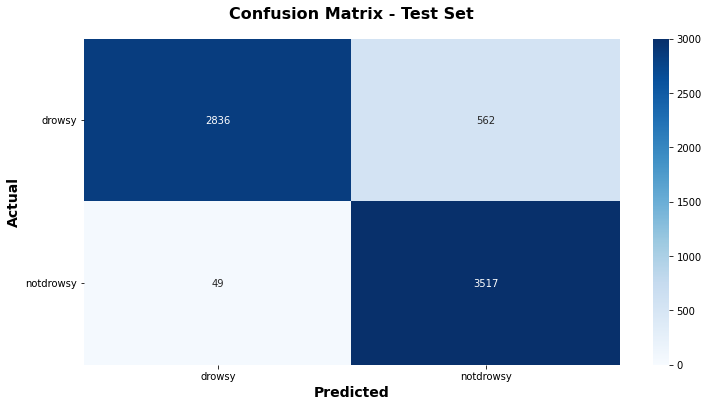

In [ ]:
classes = ["drowsy", "notdrowsy"]
CMatrix = pd.DataFrame(CM, columns=classes, index =classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 3000,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

Found 6964 images belonging to 2 classes.


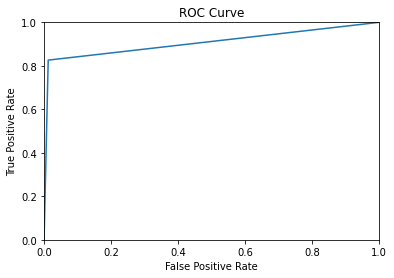

AUC =  0.9070148485615734
              precision    recall  f1-score   support

           0       0.86      0.99      0.92      3566
           1       0.98      0.83      0.90      3398

    accuracy                           0.91      6964
   macro avg       0.92      0.91      0.91      6964
weighted avg       0.92      0.91      0.91      6964



In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
modeltest = load_model('/content/drive/MyDrive/Dataset/Merged/nightglasses.h5')
test_data = test_datagen.flow_from_directory('val_data/nightglasses',target_size=(224, 224),class_mode="binary",shuffle=False)
y_pred = modeltest.predict(test_data)
predictions = np.array(list(map(lambda x: np.round(x), y_pred)))
y_true=test_data.classes

fpr , tpr , thresholds = roc_curve ( y_true , predictions)
def plot_roc_curve(fpr,tpr): 
  plt.plot(fpr,tpr) 
  plt.axis([0,1,0,1]) 
  plt.title("ROC Curve")
  plt.xlabel('False Positive Rate') 
  plt.ylabel('True Positive Rate') 
  plt.show()    
  
plot_roc_curve (fpr,tpr)
auc_score=roc_auc_score(y_true,predictions)
print("AUC = ",auc_score)

print(classification_report(y_true, predictions))

### **NoGlasses**

In [ ]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

TP = TruePositives()
TN = TrueNegatives()
FP = FalsePositives()
FN = FalseNegatives()

In [ ]:
test_data = tf.keras.utils.image_dataset_from_directory('val_data/noglasses',image_size=(224, 224))

Found 8065 files belonging to 2 classes.


In [ ]:
test_data = test_data.map(lambda x,y: (x/255, y))
for batch in test_data.as_numpy_iterator(): 
    X, y = batch
    yhat = cnn4.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)
    TP.update_state(y, yhat)
    TN.update_state(y, yhat)
    FP.update_state(y, yhat)
    FN.update_state(y, yhat)

In [ ]:
F1Measure = 2*((pre.result().numpy()*re.result().numpy())/(pre.result().numpy()+re.result().numpy()))
F1Measure = "{:.8f}".format(F1Measure)

print("Precesion   : ", pre.result().numpy())
print("Recall      : ", re.result().numpy())
print("Accuracy    : ", acc.result().numpy())
print("F1-Measure  : ", F1Measure)


print("True Positive   : ", TP.result().numpy())
print("True Negative   : ", TN.result().numpy())
print("False Positive  : ", FP.result().numpy())
print("False Negative  : ", FN.result().numpy())

Precesion   :  0.8979499
Recall      :  0.9640499
Accuracy    :  0.92650694
F1-Measure  :  0.92982662
True Positive   :  3942.0
True Negative   :  3528.0
False Positive  :  448.0
False Negative  :  147.0


In [ ]:
CM = [[int(TP.result().numpy()),int(FN.result().numpy())],[int(FP.result().numpy()),int(TN.result().numpy())]]
print(CM[0])
print(CM[1])

[3942, 147]
[448, 3528]


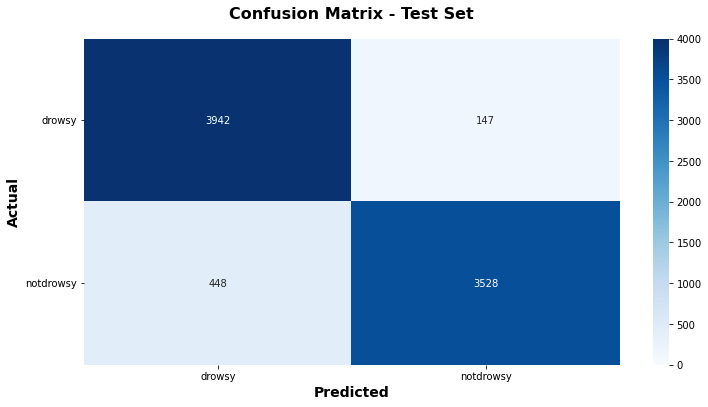

In [ ]:
classes = ["drowsy", "notdrowsy"]
CMatrix = pd.DataFrame(CM, columns=classes, index =classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 4000,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

Found 8065 images belonging to 2 classes.


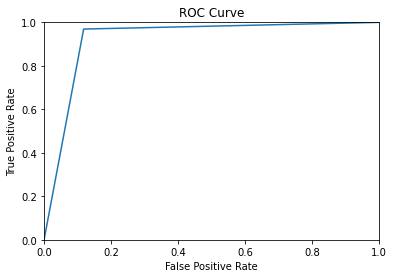

AUC =  0.9254881822113902
              precision    recall  f1-score   support

           0       0.97      0.88      0.92      3976
           1       0.89      0.97      0.93      4089

    accuracy                           0.93      8065
   macro avg       0.93      0.93      0.93      8065
weighted avg       0.93      0.93      0.93      8065



In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
modeltest = load_model('/content/drive/MyDrive/Dataset/noglasses.h5')
test_data = test_datagen.flow_from_directory('val_data/noglasses',target_size=(224, 224),class_mode="binary",shuffle=False)
y_pred = modeltest.predict(test_data)
predictions = np.array(list(map(lambda x: np.round(x), y_pred)))
y_true=test_data.classes

fpr , tpr , thresholds = roc_curve ( y_true , predictions)
def plot_roc_curve(fpr,tpr): 
  plt.plot(fpr,tpr) 
  plt.axis([0,1,0,1]) 
  plt.title("ROC Curve")
  plt.xlabel('False Positive Rate') 
  plt.ylabel('True Positive Rate') 
  plt.show()    
  
plot_roc_curve (fpr,tpr)
auc_score=roc_auc_score(y_true,predictions)
print("AUC = ",auc_score)

print(classification_report(y_true, predictions))

### **Glasses**

In [ ]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

TP = TruePositives()
TN = TrueNegatives()
FP = FalsePositives()
FN = FalseNegatives()

In [ ]:
test_data = tf.keras.utils.image_dataset_from_directory('val_data/glasses',image_size=(224, 224))

Found 6174 files belonging to 2 classes.


In [ ]:
test_data = test_data.map(lambda x,y: (x/255, y))
for batch in test_data.as_numpy_iterator(): 
    X, y = batch
    yhat = cnn5.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)
    TP.update_state(y, yhat)
    TN.update_state(y, yhat)
    FP.update_state(y, yhat)
    FN.update_state(y, yhat)

In [ ]:
F1Measure = 2*((pre.result().numpy()*re.result().numpy())/(pre.result().numpy()+re.result().numpy()))
F1Measure = "{:.8f}".format(F1Measure)

print("Precesion   : ", pre.result().numpy())
print("Recall      : ", re.result().numpy())
print("Accuracy    : ", acc.result().numpy())
print("F1-Measure  : ", F1Measure)


print("True Positive   : ", TP.result().numpy())
print("True Negative   : ", TN.result().numpy())
print("False Positive  : ", FP.result().numpy())
print("False Negative  : ", FN.result().numpy())

Precesion   :  0.9902873
Recall      :  0.93539757
Accuracy    :  0.9687284
F1-Measure  :  0.96206009
True Positive   :  2447.0
True Negative   :  3534.0
False Positive  :  24.0
False Negative  :  169.0


In [ ]:
CM = [[int(TP.result().numpy()),int(FN.result().numpy())],[int(FP.result().numpy()),int(TN.result().numpy())]]
print(CM[0])
print(CM[1])

[2447, 169]
[24, 3534]


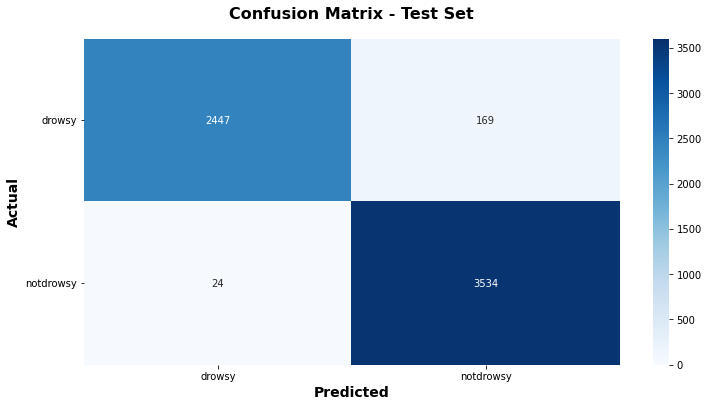

In [ ]:
classes = ["drowsy", "notdrowsy"]
CMatrix = pd.DataFrame(CM, columns=classes, index =classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 3600,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

Found 6174 images belonging to 2 classes.


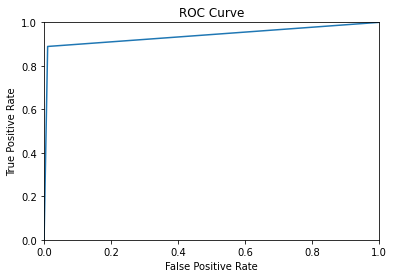

AUC =  0.9392317867475285
              precision    recall  f1-score   support

           0       0.92      0.99      0.96      3558
           1       0.98      0.89      0.93      2616

    accuracy                           0.95      6174
   macro avg       0.95      0.94      0.94      6174
weighted avg       0.95      0.95      0.95      6174



In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
modeltest = load_model('/content/drive/MyDrive/Dataset/glasses.h5')
test_data = test_datagen.flow_from_directory('val_data/glasses',target_size=(224, 224),class_mode="binary",shuffle=False)
y_pred = modeltest.predict(test_data)
predictions = np.array(list(map(lambda x: np.round(x), y_pred)))
y_true=test_data.classes

fpr , tpr , thresholds = roc_curve ( y_true , predictions)
def plot_roc_curve(fpr,tpr): 
  plt.plot(fpr,tpr) 
  plt.axis([0,1,0,1]) 
  plt.title("ROC Curve")
  plt.xlabel('False Positive Rate') 
  plt.ylabel('True Positive Rate') 
  plt.show()    
  
plot_roc_curve (fpr,tpr)
auc_score=roc_auc_score(y_true,predictions)
print("AUC = ",auc_score)

print(classification_report(y_true, predictions))

### **Night_NoGlasses**

In [ ]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

TP = TruePositives()
TN = TrueNegatives()
FP = FalsePositives()
FN = FalseNegatives()

In [ ]:
test_data = tf.keras.utils.image_dataset_from_directory('val_data/night_noglasses',image_size=(224, 224))

Found 8052 files belonging to 2 classes.


In [ ]:
test_data = test_data.map(lambda x,y: (x/255, y))
for batch in test_data.as_numpy_iterator(): 
    X, y = batch
    yhat = cnn6.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)
    TP.update_state(y, yhat)
    TN.update_state(y, yhat)
    FP.update_state(y, yhat)
    FN.update_state(y, yhat)

In [ ]:
F1Measure = 2*((pre.result().numpy()*re.result().numpy())/(pre.result().numpy()+re.result().numpy()))
F1Measure = "{:.8f}".format(F1Measure)

print("Precesion   : ", pre.result().numpy())
print("Recall      : ", re.result().numpy())
print("Accuracy    : ", acc.result().numpy())
print("F1-Measure  : ", F1Measure)


print("True Positive   : ", TP.result().numpy())
print("True Negative   : ", TN.result().numpy())
print("False Positive  : ", FP.result().numpy())
print("False Negative  : ", FN.result().numpy())

Precesion   :  0.9060921
Recall      :  0.99477977
Accuracy    :  0.9586805
F1-Measure  :  0.94836706
True Positive   :  3049.0
True Negative   :  4671.0
False Positive  :  316.0
False Negative  :  16.0


In [ ]:
CM = [[int(TP.result().numpy()),int(FN.result().numpy())],[int(FP.result().numpy()),int(TN.result().numpy())]]
print(CM[0])
print(CM[1])

[3049, 16]
[316, 4671]


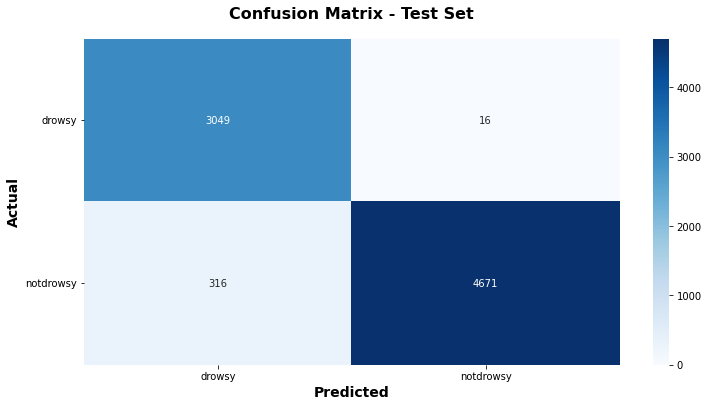

In [ ]:
classes = ["drowsy", "notdrowsy"]
CMatrix = pd.DataFrame(CM, columns=classes, index =classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 4700,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

Found 8052 images belonging to 2 classes.


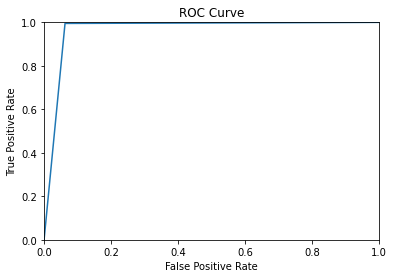

AUC =  0.9662716864827344
              precision    recall  f1-score   support

           0       1.00      0.94      0.97      4987
           1       0.91      1.00      0.95      3065

    accuracy                           0.96      8052
   macro avg       0.95      0.97      0.96      8052
weighted avg       0.96      0.96      0.96      8052



In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
modeltest = load_model('/content/drive/MyDrive/Dataset/night_noglasses.h5')
test_data = test_datagen.flow_from_directory('val_data/night_noglasses',target_size=(224, 224),class_mode="binary",shuffle=False)
y_pred = modeltest.predict(test_data)
predictions = np.array(list(map(lambda x: np.round(x), y_pred)))
y_true=test_data.classes

fpr , tpr , thresholds = roc_curve ( y_true , predictions)
def plot_roc_curve(fpr,tpr): 
  plt.plot(fpr,tpr) 
  plt.axis([0,1,0,1]) 
  plt.title("ROC Curve")
  plt.xlabel('False Positive Rate') 
  plt.ylabel('True Positive Rate') 
  plt.show()    
  
plot_roc_curve (fpr,tpr)
auc_score=roc_auc_score(y_true,predictions)
print("AUC = ",auc_score)

print(classification_report(y_true, predictions))

### **SunGlasses**

In [ ]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

TP = TruePositives()
TN = TrueNegatives()
FP = FalsePositives()
FN = FalseNegatives()

In [ ]:
test_data = tf.keras.utils.image_dataset_from_directory('val_data/sunglasses',image_size=(224, 224))

Found 5168 files belonging to 2 classes.


In [ ]:
test_data = test_data.map(lambda x,y: (x/255, y))
for batch in test_data.as_numpy_iterator(): 
    X, y = batch
    yhat = cnn7.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)
    TP.update_state(y, yhat)
    TN.update_state(y, yhat)
    FP.update_state(y, yhat)
    FN.update_state(y, yhat)

In [ ]:
F1Measure = 2*((pre.result().numpy()*re.result().numpy())/(pre.result().numpy()+re.result().numpy()))
F1Measure = "{:.8f}".format(F1Measure)

print("Precesion   : ", pre.result().numpy())
print("Recall      : ", re.result().numpy())
print("Accuracy    : ", acc.result().numpy())
print("F1-Measure  : ", F1Measure)


print("True Positive   : ", TP.result().numpy())
print("True Negative   : ", TN.result().numpy())
print("False Positive  : ", FP.result().numpy())
print("False Negative  : ", FN.result().numpy())

Precesion   :  0.7924025
Recall      :  0.9592578
Accuracy    :  0.8603395
F1-Measure  :  0.86788315
True Positive   :  2378.0
True Negative   :  2066.0
False Positive  :  623.0
False Negative  :  101.0


In [ ]:
CM = [[int(TP.result().numpy()),int(FN.result().numpy())],[int(FP.result().numpy()),int(TN.result().numpy())]]
print(CM[0])
print(CM[1])

[2378, 101]
[623, 2066]


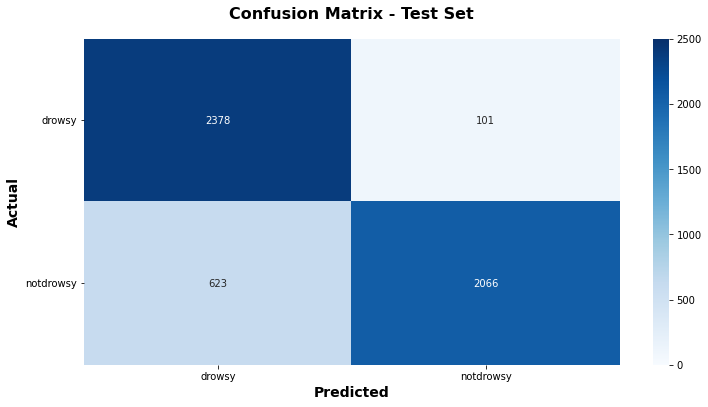

In [ ]:
classes = ["drowsy", "notdrowsy"]
CMatrix = pd.DataFrame(CM, columns=classes, index =classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 2500,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

Found 5168 images belonging to 2 classes.


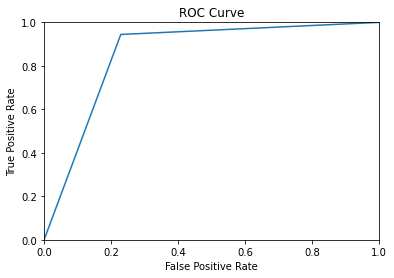

AUC =  0.8576254745890021
              precision    recall  f1-score   support

           0       0.94      0.77      0.85      2689
           1       0.79      0.94      0.86      2479

    accuracy                           0.85      5168
   macro avg       0.86      0.86      0.85      5168
weighted avg       0.87      0.85      0.85      5168



In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
modeltest = load_model('/content/drive/MyDrive/Dataset/sunglasses.h5')
test_data = test_datagen.flow_from_directory('val_data/sunglasses',target_size=(224, 224),class_mode="binary",shuffle=False)
y_pred = modeltest.predict(test_data)
predictions = np.array(list(map(lambda x: np.round(x), y_pred)))
y_true=test_data.classes

fpr , tpr , thresholds = roc_curve ( y_true , predictions)
def plot_roc_curve(fpr,tpr): 
  plt.plot(fpr,tpr) 
  plt.axis([0,1,0,1]) 
  plt.title("ROC Curve")
  plt.xlabel('False Positive Rate') 
  plt.ylabel('True Positive Rate') 
  plt.show()    
  
plot_roc_curve (fpr,tpr)
auc_score=roc_auc_score(y_true,predictions)
print("AUC = ",auc_score)

print(classification_report(y_true, predictions))

### **With All Mergerd Data**

In [ ]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

TP = TruePositives()
TN = TrueNegatives()
FP = FalsePositives()
FN = FalseNegatives()

In [ ]:
test_data = tf.keras.utils.image_dataset_from_directory('val',image_size=(224, 224))

Found 34423 files belonging to 2 classes.


In [ ]:
test_data = test_data.map(lambda x,y: (x/255, y))
for batch in test_data.as_numpy_iterator(): 
    X, y = batch
    yhat = cnn8.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)
    TP.update_state(y, yhat)
    TN.update_state(y, yhat)
    FP.update_state(y, yhat)
    FN.update_state(y, yhat)

In [ ]:
F1Measure = 2*((pre.result().numpy()*re.result().numpy())/(pre.result().numpy()+re.result().numpy()))
F1Measure = "{:.8f}".format(F1Measure)

print("Precesion   : ", pre.result().numpy())
print("Recall      : ", re.result().numpy())
print("Accuracy    : ", acc.result().numpy())
print("F1-Measure  : ", F1Measure)


print("True Positive   : ", TP.result().numpy())
print("True Negative   : ", TN.result().numpy())
print("False Positive  : ", FP.result().numpy())
print("False Negative  : ", FN.result().numpy())

Precesion   :  0.8368362
Recall      :  0.9567968
Accuracy    :  0.8955572
F1-Measure  :  0.89280498
True Positive   :  14971.0
True Negative   :  15857.0
False Positive  :  2919.0
False Negative  :  676.0


In [ ]:
CM = [[int(TP.result().numpy()),int(FN.result().numpy())],[int(FP.result().numpy()),int(TN.result().numpy())]]
print(CM[0])
print(CM[1])

[14971, 676]
[2919, 15857]


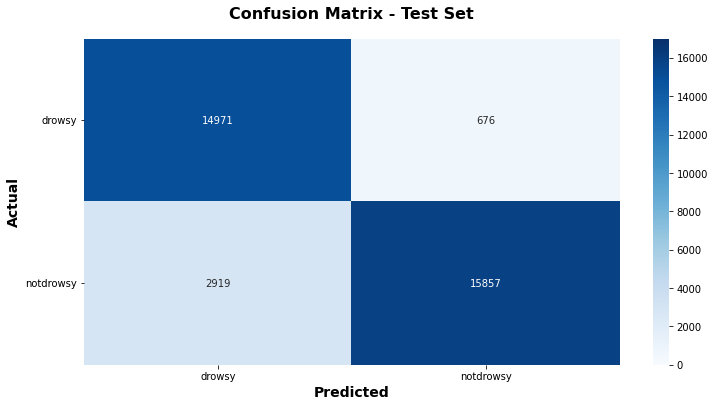

In [ ]:
classes = ["drowsy", "notdrowsy"]
CMatrix = pd.DataFrame(CM, columns=classes, index =classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 17000,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

Found 34423 images belonging to 2 classes.


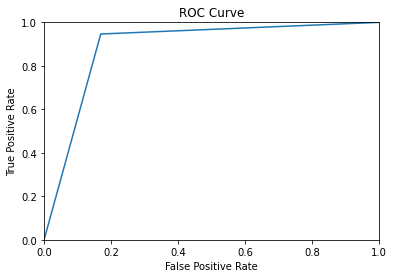

AUC =  0.8885923898230966
              precision    recall  f1-score   support

           0       0.95      0.83      0.89     18776
           1       0.82      0.95      0.88     15647

    accuracy                           0.88     34423
   macro avg       0.89      0.89      0.88     34423
weighted avg       0.89      0.88      0.88     34423



In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
modeltest = load_model('/content/drive/MyDrive/Dataset/Merged/all.h5')
test_data = test_datagen.flow_from_directory('val',target_size=(224, 224),class_mode="binary",shuffle=False)
y_pred = modeltest.predict(test_data)
predictions = np.array(list(map(lambda x: np.round(x), y_pred)))
y_true=test_data.classes

fpr , tpr , thresholds = roc_curve ( y_true , predictions)
def plot_roc_curve(fpr,tpr): 
  plt.plot(fpr,tpr) 
  plt.axis([0,1,0,1]) 
  plt.title("ROC Curve")
  plt.xlabel('False Positive Rate') 
  plt.ylabel('True Positive Rate') 
  plt.show()    
  
plot_roc_curve (fpr,tpr)
auc_score=roc_auc_score(y_true,predictions)
print("AUC = ",auc_score)

print(classification_report(y_true, predictions))

### **With All Merged Data refined**

In [ ]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

TP = TruePositives()
TN = TrueNegatives()
FP = FalsePositives()
FN = FalseNegatives()

In [ ]:
test_data = tf.keras.utils.image_dataset_from_directory('val',image_size=(224, 224))

Found 34423 files belonging to 2 classes.


In [ ]:
test_data = test_data.map(lambda x,y: (x/255, y))
for batch in test_data.as_numpy_iterator(): 
    X, y = batch
    yhat = cnn8.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)
    TP.update_state(y, yhat)
    TN.update_state(y, yhat)
    FP.update_state(y, yhat)
    FN.update_state(y, yhat)

In [ ]:
F1Measure = 2*((pre.result().numpy()*re.result().numpy())/(pre.result().numpy()+re.result().numpy()))
F1Measure = "{:.8f}".format(F1Measure)

print("Precesion   : ", pre.result().numpy())
print("Recall      : ", re.result().numpy())
print("Accuracy    : ", acc.result().numpy())
print("F1-Measure  : ", F1Measure)


print("True Positive   : ", TP.result().numpy())
print("True Negative   : ", TN.result().numpy())
print("False Positive  : ", FP.result().numpy())
print("False Negative  : ", FN.result().numpy())

Precesion   :  0.8780332
Recall      :  0.966639
Accuracy    :  0.92379814
F1-Measure  :  0.92020804
True Positive   :  15125.0
True Negative   :  16675.0
False Positive  :  2101.0
False Negative  :  522.0


In [ ]:
CM = [[int(TP.result().numpy()),int(FN.result().numpy())],[int(FP.result().numpy()),int(TN.result().numpy())]]
print(CM[0])
print(CM[1])

[15125, 522]
[2101, 16675]


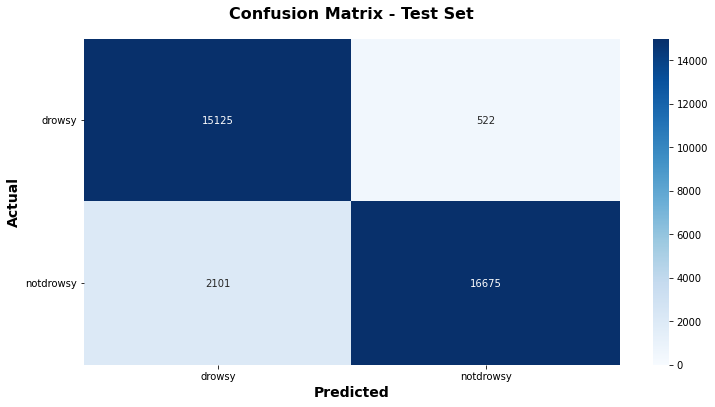

In [ ]:
classes = ["drowsy", "notdrowsy"]
CMatrix = pd.DataFrame(CM, columns=classes, index =classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 15000,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

Found 34423 images belonging to 2 classes.


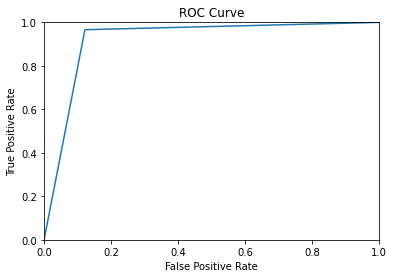

AUC =  0.9220923918245395
              precision    recall  f1-score   support

           0       0.97      0.88      0.92     18776
           1       0.87      0.97      0.91     15647

    accuracy                           0.92     34423
   macro avg       0.92      0.92      0.92     34423
weighted avg       0.92      0.92      0.92     34423



In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
modeltest = load_model('/content/drive/MyDrive/Dataset/full_model.h5')
test_data = test_datagen.flow_from_directory('val',target_size=(224, 224),class_mode="binary",shuffle=False)
y_pred = modeltest.predict(test_data)
predictions = np.array(list(map(lambda x: np.round(x), y_pred)))
y_true=test_data.classes

fpr , tpr , thresholds = roc_curve ( y_true , predictions)
def plot_roc_curve(fpr,tpr): 
  plt.plot(fpr,tpr) 
  plt.axis([0,1,0,1]) 
  plt.title("ROC Curve")
  plt.xlabel('False Positive Rate') 
  plt.ylabel('True Positive Rate') 
  plt.show()    
  
plot_roc_curve (fpr,tpr)
auc_score=roc_auc_score(y_true,predictions)
print("AUC = ",auc_score)

print(classification_report(y_true, predictions))

## **Playground**

In [ ]:
#augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1./255)

batchs = 32

train_generator=train_datagen.flow_from_directory(
    directory='train_data/sunglasses',
    target_size=(224, 224),
    batch_size=batchs,
    class_mode="binary",
    shuffle=True
)

valid_generator=test_datagen.flow_from_directory(
    directory='val_data/sunglasses',
    target_size=(224, 224),
    batch_size=batchs,
    class_mode="binary",
    shuffle=True
)


Found 194150 images belonging to 2 classes.
Found 34423 images belonging to 2 classes.


In [ ]:
#sunglasses
cnn7 = models.Sequential()
cnn7.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224,224,3)))
cnn7.add(layers.MaxPooling2D((2, 2)))

cnn7.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn7.add(layers.MaxPooling2D((2, 2)))

cnn7.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn7.add(layers.MaxPooling2D((2, 2)))

cnn7.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn7.add(layers.MaxPooling2D((2, 2)))

cnn7.add(layers.Dropout(0.20))
cnn7.add(layers.Flatten())

cnn7.add(layers.Dense(512, activation='relu', kernel_regularizer=l2(0.01)))
cnn7.add(layers.Dropout(0.15))
cnn7.add(layers.Dense(1, activation='sigmoid'))
cnn7.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 26, 26, 128)     

In [ ]:
cnn7.compile(optimizer='Adam',
             loss='binary_crossentropy',
             metrics=['accuracy']
             )

In [ ]:
history_5=cnn7.fit(train_generator,
                          steps_per_epoch= (train_generator.samples)/train_generator.batch_size,
                          epochs=10, 
                          verbose=1,
                          validation_data=valid_generator,
                          validation_steps = (valid_generator.samples)/valid_generator.batch_size,
               )

Epoch 1/10
1188/1188 [==============================] - 380s 320ms/step - loss: 0.4779 - accuracy: 0.8689 - val_loss: 0.7614 - val_accuracy: 0.6358
Epoch 2/10
1188/1188 [==============================] - 375s 315ms/step - loss: 0.2814 - accuracy: 0.9313 - val_loss: 0.8659 - val_accuracy: 0.7637
Epoch 3/10
1188/1188 [==============================] - 375s 315ms/step - loss: 0.2355 - accuracy: 0.9454 - val_loss: 0.8037 - val_accuracy: 0.8229
Epoch 4/10
1188/1188 [==============================] - 374s 315ms/step - loss: 0.2060 - accuracy: 0.9523 - val_loss: 0.9228 - val_accuracy: 0.8644
Epoch 5/10
1188/1188 [==============================] - 375s 315ms/step - loss: 0.1905 - accuracy: 0.9563 - val_loss: 0.4990 - val_accuracy: 0.8380
Epoch 6/10
1188/1188 [==============================] - 376s 316ms/step - loss: 0.1691 - accuracy: 0.9610 - val_loss: 0.8243 - val_accuracy: 0.8630
Epoch 7/10
1188/1188 [==============================] - 376s 316ms/step - loss: 0.1608 - accuracy: 0.9631 - val_

### **Sunglasses plot**

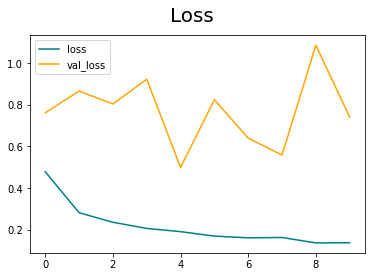

In [ ]:
fig = plt.figure()
plt.plot(history_5.history['loss'], color='teal', label='loss')
plt.plot(history_5.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

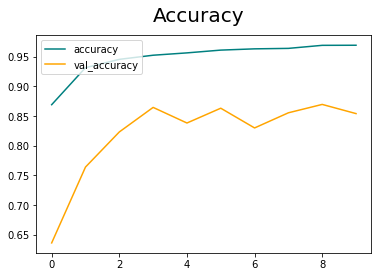

In [ ]:
fig = plt.figure()
plt.plot(history_5.history['accuracy'], color='teal', label='accuracy')
plt.plot(history_5.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

### **Sunglasses before**

In [ ]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

TP = TruePositives()
TN = TrueNegatives()
FP = FalsePositives()
FN = FalseNegatives()

In [ ]:
test_data = tf.keras.utils.image_dataset_from_directory('val_data/sunglasses',image_size=(224, 224))

Found 5168 files belonging to 2 classes.


In [ ]:
test_data = test_data.map(lambda x,y: (x/255, y))
for batch in test_data.as_numpy_iterator(): 
    X, y = batch
    yhat = cnn7.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)
    TP.update_state(y, yhat)
    TN.update_state(y, yhat)
    FP.update_state(y, yhat)
    FN.update_state(y, yhat)

In [ ]:
F1Measure = 2*((pre.result().numpy()*re.result().numpy())/(pre.result().numpy()+re.result().numpy()))
F1Measure = "{:.8f}".format(F1Measure)

print("Precesion   : ", pre.result().numpy())
print("Recall      : ", re.result().numpy())
print("Accuracy    : ", acc.result().numpy())
print("F1-Measure  : ", F1Measure)


print("True Positive   : ", TP.result().numpy())
print("True Negative   : ", TN.result().numpy())
print("False Positive  : ", FP.result().numpy())
print("False Negative  : ", FN.result().numpy())

Precesion   :  0.78764606
Recall      :  0.9515934
Accuracy    :  0.853588
F1-Measure  :  0.86189258
True Positive   :  2359.0
True Negative   :  2053.0
False Positive  :  636.0
False Negative  :  120.0


In [ ]:
CM = [[int(TP.result().numpy()),int(FN.result().numpy())],[int(FP.result().numpy()),int(TN.result().numpy())]]
print(CM[0])
print(CM[1])

[2359, 120]
[636, 2053]


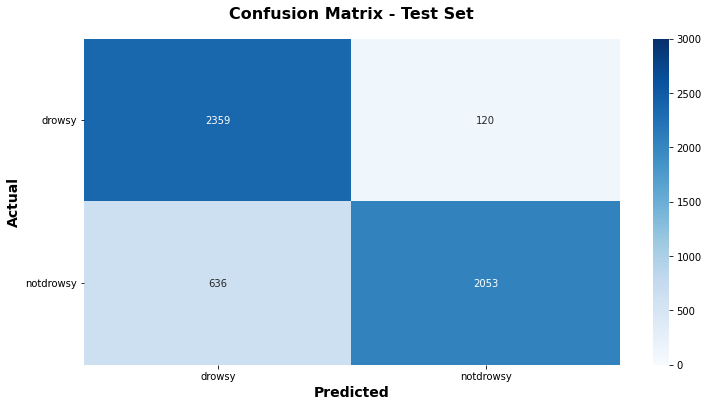

In [ ]:
classes = ["drowsy", "notdrowsy"]
CMatrix = pd.DataFrame(CM, columns=classes, index =classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 3000,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

# **VGG16**

In [ ]:
batch_size = 32
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        'train',  
        target_size=(224, 224),  
        batch_size=batch_size,
        class_mode='binary',
        shuffle = True) 

validation_generator = test_datagen.flow_from_directory(
        'val',
        target_size=(224,224),
        batch_size=batch_size,
        class_mode='binary')

Found 194150 images belonging to 2 classes.
Found 34423 images belonging to 2 classes.


In [ ]:
vgg = VGG16(
    include_top=False, weights='imagenet', input_tensor=None, input_shape= (224,224,3),
)

for layer in vgg.layers:
    layer.trainable = False

#for layer in vgg.layers:
    #print(layer, layer.trainable)

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
model_vgg = Sequential()

model_vgg.add(vgg)
model_vgg.add(Flatten())
model_vgg.add(Dropout(0.20))
model_vgg.add(Dense(512, activation='relu'))
model_vgg.add(Dropout(0.15))
model_vgg.add(Dense(1, activation='sigmoid'))

model_vgg.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_6 (Flatten)         (None, 25088)             0         
                                                                 
 dropout_8 (Dropout)         (None, 25088)             0         
                                                                 
 dense_17 (Dense)            (None, 512)               12845568  
                                                                 
 dropout_9 (Dropout)         (None, 512)               0         
                                                                 
 dense_18 (Dense)            (None, 1)                 513       
                                                                 
Total params: 27,560,769
Trainable params: 12,846,081


In [ ]:
#plot_model(model_vgg, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
#plot_model(model_vgg)

In [ ]:
model_vgg.compile(loss='binary_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])


history_vgg = model_vgg.fit(
      train_generator,
      steps_per_epoch= (train_generator.samples)/train_generator.batch_size,
      epochs=15,
      validation_data=validation_generator, 
      validation_steps=(validation_generator.samples)/validation_generator.batch_size,
      verbose=1)

Epoch 1/15
6067/6067 [==============================] - 2148s 354ms/step - loss: 0.1579 - accuracy: 0.9377 - val_loss: 0.5263 - val_accuracy: 0.7621
Epoch 2/15
6067/6067 [==============================] - 2162s 356ms/step - loss: 0.0964 - accuracy: 0.9636 - val_loss: 0.5985 - val_accuracy: 0.7440
Epoch 3/15
6067/6067 [==============================] - 2139s 353ms/step - loss: 0.0770 - accuracy: 0.9712 - val_loss: 0.4752 - val_accuracy: 0.7943
Epoch 4/15
6067/6067 [==============================] - 2120s 349ms/step - loss: 0.0683 - accuracy: 0.9753 - val_loss: 0.4886 - val_accuracy: 0.7838
Epoch 5/15
6067/6067 [==============================] - 2123s 350ms/step - loss: 0.0606 - accuracy: 0.9781 - val_loss: 0.7157 - val_accuracy: 0.7535
Epoch 6/15
6067/6067 [==============================] - 2146s 354ms/step - loss: 0.0566 - accuracy: 0.9797 - val_loss: 0.5274 - val_accuracy: 0.7579
Epoch 7/15
6067/6067 [==============================] - 2156s 355ms/step - loss: 0.0530 - accuracy: 0.9812

In [ ]:
model_vgg.save('/content/drive/MyDrive/Dataset/VGG16_Drowsiness.h5')

### **Plot Performance**

In [ ]:
fig = plt.figure()
plt.plot(history_vgg.history['loss'], color='teal', label='loss')
plt.plot(history_vgg.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
fig = plt.figure()
plt.plot(history_vgg.history['accuracy'], color='teal', label='accuracy')
plt.plot(history_vgg.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
def visualize_results(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()
visualize_results(history_vgg)

### **Confusion Matrix**

In [ ]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

TP = TruePositives()
TN = TrueNegatives()
FP = FalsePositives()
FN = FalseNegatives()

In [ ]:
test_data = tf.keras.utils.image_dataset_from_directory('val',image_size=(224, 224))

Found 34423 files belonging to 2 classes.


In [ ]:
test_data = test_data.map(lambda x,y: (x/255, y))
for batch in test_data.as_numpy_iterator(): 
    X, y = batch
    yhat = model_vgg.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)
    TP.update_state(y, yhat)
    TN.update_state(y, yhat)
    FP.update_state(y, yhat)
    FN.update_state(y, yhat)

In [ ]:
F1Measure = 2*((pre.result().numpy()*re.result().numpy())/(pre.result().numpy()+re.result().numpy()))
F1Measure = "{:.8f}".format(F1Measure)

print("Precesion   : ", pre.result().numpy())
print("Recall      : ", re.result().numpy())
print("Accuracy    : ", acc.result().numpy())
print("F1-Measure  : ", F1Measure)


print("True Positive   : ", TP.result().numpy())
print("True Negative   : ", TN.result().numpy())
print("False Positive  : ", FP.result().numpy())
print("False Negative  : ", FN.result().numpy())

In [ ]:
CM = [[int(TP.result().numpy()),int(FN.result().numpy())],[int(FP.result().numpy()),int(TN.result().numpy())]]
print(CM[0])
print(CM[1])

In [ ]:
classes = ["drowsy", "notdrowsy"]
CMatrix = pd.DataFrame(CM, columns=classes, index =classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 3000,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

# **Detect Irresponsible Behavior**

## **Data Load**

In [ ]:
#unprocessed dataset
!unzip gdrive/My\ Drive/Dataset/Irresponsible_behavior_before.zip

In [ ]:
!unzip gdrive/My\ Drive/Dataset/Irresponsible_Behavior.zip

Streaming output truncated to the last 5000 lines.
  inflating: Irresponsible_Behavior/img/valid/c0/img_67217.jpg  
  inflating: Irresponsible_Behavior/img/valid/c0/img_67255.jpg  
  inflating: Irresponsible_Behavior/img/valid/c0/img_67547.jpg  
  inflating: Irresponsible_Behavior/img/valid/c0/img_67639.jpg  
  inflating: Irresponsible_Behavior/img/valid/c0/img_67874.jpg  
  inflating: Irresponsible_Behavior/img/valid/c0/img_68134.jpg  
  inflating: Irresponsible_Behavior/img/valid/c0/img_68246.jpg  
  inflating: Irresponsible_Behavior/img/valid/c0/img_68304.jpg  
  inflating: Irresponsible_Behavior/img/valid/c0/img_68450.jpg  
  inflating: Irresponsible_Behavior/img/valid/c0/img_68539.jpg  
  inflating: Irresponsible_Behavior/img/valid/c0/img_68662.jpg  
  inflating: Irresponsible_Behavior/img/valid/c0/img_68766.jpg  
  inflating: Irresponsible_Behavior/img/valid/c0/img_6898.jpg  
  inflating: Irresponsible_Behavior/img/valid/c0/img_69086.jpg  
  inflating: Irresponsible_Behavior/img/

In [ ]:
main_folder="Irresponsible_behavior_before/"

In [ ]:
df_driver=pd.read_csv(main_folder+"driver_imgs_list.csv")
len(df_driver)

22424

In [ ]:
df_driver.head()

subject classname            img
0    p002        c0  img_44733.jpg
1    p002        c0  img_72999.jpg
2    p002        c0  img_25094.jpg
3    p002        c0  img_69092.jpg
4    p002        c0  img_92629.jpg

In [ ]:
count=0
main_folder="Irresponsible_behavior_before/"
file_path=main_folder+"imgs/train"
counts={}
for folder in os.listdir(file_path):
    class_count=0
    images=gb.glob(pathname=str(file_path+'/'+folder+'/*.*'))
    for img in images:
        count+=1
        class_count+=1
    num_image={f"{folder}":class_count}
    counts.update(num_image)
    print(f"the number of images in class {folder}: {class_count}")
    print()
print()
print(f"The Total Number of Images: {count}")

the number of images in class c2: 2317

the number of images in class c6: 2325

the number of images in class c0: 2489

the number of images in class c1: 2267

the number of images in class c5: 2312

the number of images in class c3: 2346

the number of images in class c9: 2129

the number of images in class c4: 2326

the number of images in class c7: 2002

the number of images in class c8: 1911


The Total Number of Images: 22424


<BarContainer object of 10 artists>

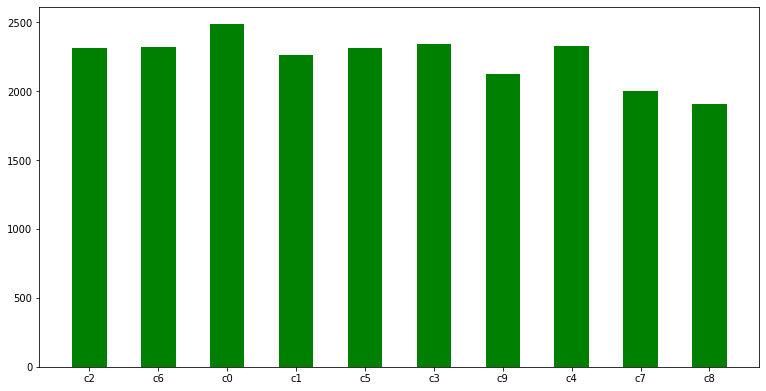

In [ ]:
fig=plt.figure(figsize=(10,5))
ax = fig.add_axes([0,0,1,1])
ax.bar(list(counts.keys()) , list(counts.values()), color = 'green',width=0.5)

In [ ]:
classes_name = {  'c0' : "safe_driving",
                  'c1' : "texting-right",
                  'c2' : "talking_on_the_phone-right",
                  'c3' : "texting-left",
                  'c4' : "talking_on_the_phone-left",
                  'c5' : "operating_the_radio",
                  'c6' : "drinking",
                  'c7' : "reaching_behind",
                  'c8' : "hair-and-makeup",
                  'c9' : "talking_to_passenger"}

In [ ]:
df_driver.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22424 entries, 0 to 22423
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subject    22424 non-null  object
 1   classname  22424 non-null  object
 2   img        22424 non-null  object
dtypes: object(3)
memory usage: 525.7+ KB


In [ ]:
from sklearn.utils import shuffle

imgs=[]
names=[]
for label in list(classes_name.keys()):
    imgs_name=shuffle(df_driver[df_driver["classname"] == label])["img"][:5]
    imgs.extend(imgs_name)
    names.extend(((label+" ")*5).split())

print(imgs)
print(names)

['img_74002.jpg', 'img_44655.jpg', 'img_82948.jpg', 'img_63832.jpg', 'img_78110.jpg', 'img_30111.jpg', 'img_57326.jpg', 'img_83426.jpg', 'img_11776.jpg', 'img_96129.jpg', 'img_88563.jpg', 'img_81418.jpg', 'img_41980.jpg', 'img_49745.jpg', 'img_8883.jpg', 'img_73824.jpg', 'img_49082.jpg', 'img_5260.jpg', 'img_14597.jpg', 'img_96052.jpg', 'img_85756.jpg', 'img_50534.jpg', 'img_59158.jpg', 'img_33866.jpg', 'img_92859.jpg', 'img_70297.jpg', 'img_59175.jpg', 'img_42692.jpg', 'img_27772.jpg', 'img_50894.jpg', 'img_22793.jpg', 'img_90717.jpg', 'img_82544.jpg', 'img_4797.jpg', 'img_40197.jpg', 'img_60530.jpg', 'img_36431.jpg', 'img_18056.jpg', 'img_54003.jpg', 'img_33607.jpg', 'img_53436.jpg', 'img_81314.jpg', 'img_75915.jpg', 'img_39053.jpg', 'img_83735.jpg', 'img_2370.jpg', 'img_53157.jpg', 'img_29551.jpg', 'img_1055.jpg', 'img_8039.jpg']
['c0', 'c0', 'c0', 'c0', 'c0', 'c1', 'c1', 'c1', 'c1', 'c1', 'c2', 'c2', 'c2', 'c2', 'c2', 'c3', 'c3', 'c3', 'c3', 'c3', 'c4', 'c4', 'c4', 'c4', 'c4', 'c5'

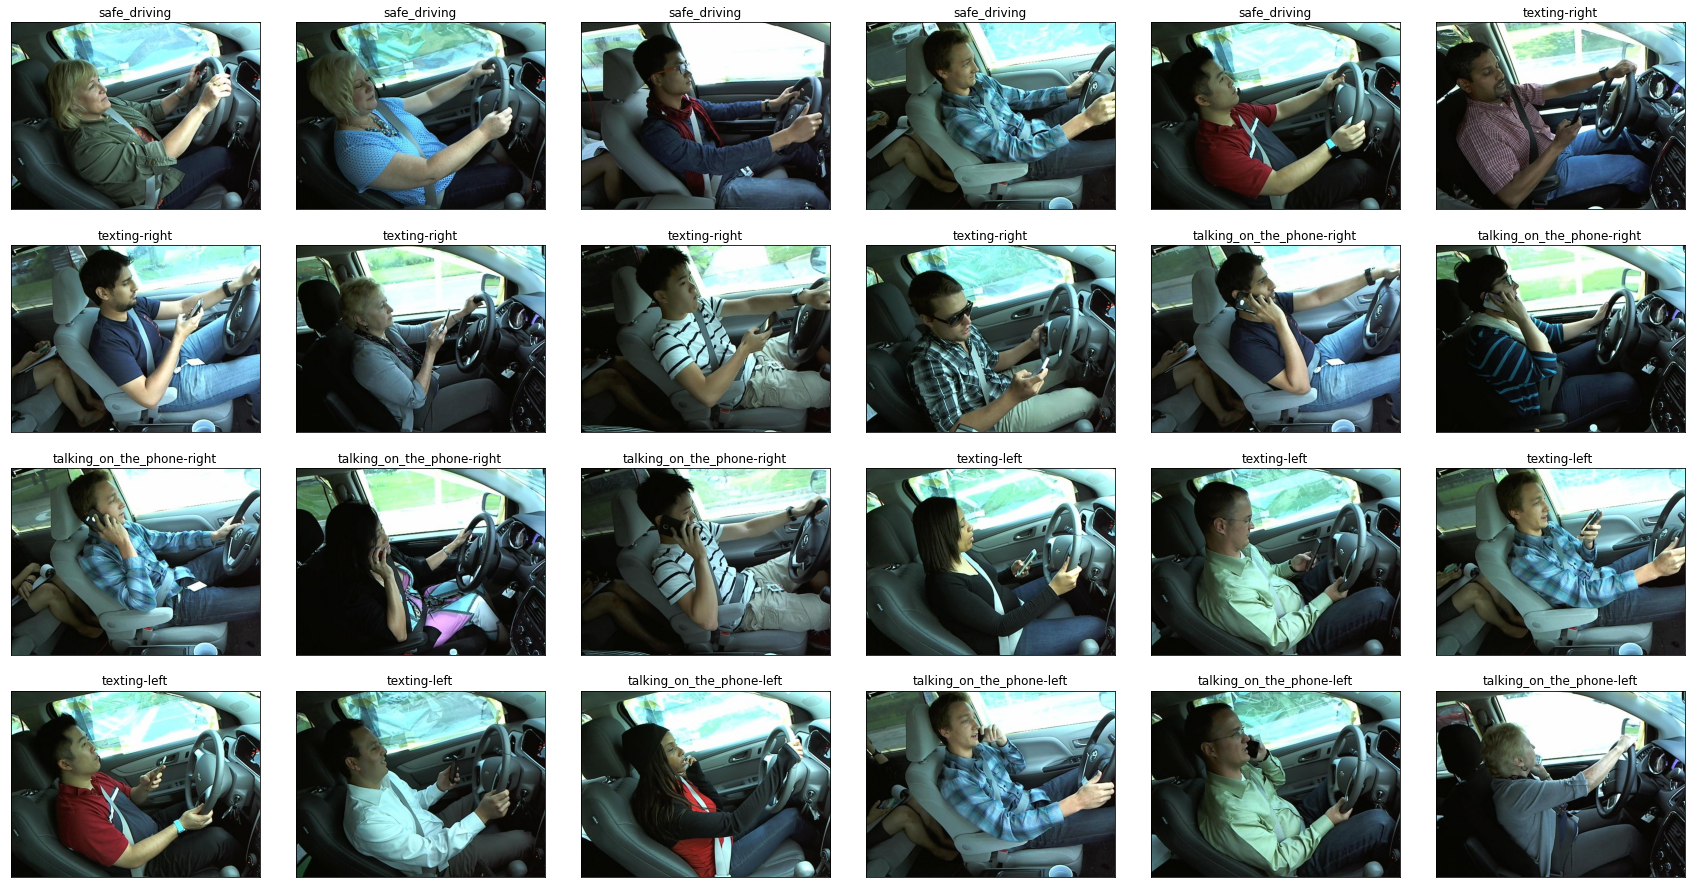

In [ ]:
fig = plt.figure(figsize=(30, 30))
grid = ImageGrid(fig, 111, 
                 nrows_ncols=(4, 6), 
                 axes_pad=0.5, label_mode='all' 
)
i=0
file_path=main_folder+"imgs/train/"
for axes in grid:
    img=cv2.imread(file_path+names[i]+"/"+imgs[i])
    rgb_img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes.imshow(rgb_img)
    axes.xaxis.set_visible(False)
    axes.yaxis.set_visible(False)
    axes.set_title(classes_name.get(names[i]))
    i+=1

plt.show()

## **Data Preprocessing**

In [ ]:
x_data=df_driver["img"]
y_data=df_driver["classname"]

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(x_data,y_data,test_size = 0.4, random_state = 42,shuffle=True)

In [ ]:
x_valid,xtest,y_valid,ytest=train_test_split(x_test,y_test,test_size = 0.4, random_state = 42,shuffle=True)

In [ ]:
y_train.value_counts()

c0    1498
c3    1421
c2    1403
c4    1387
c5    1367
c6    1364
c1    1362
c9    1313
c7    1210
c8    1129
Name: classname, dtype: int64

In [ ]:
y_valid.value_counts()

c0    598
c6    581
c4    578
c5    571
c2    558
c3    558
c1    529
c9    482
c7    478
c8    449
Name: classname, dtype: int64

In [ ]:
ytest.value_counts()

c0    393
c6    380
c1    376
c5    374
c3    367
c4    361
c2    356
c9    334
c8    333
c7    314
Name: classname, dtype: int64

In [ ]:
x_train = pd.DataFrame(x_train.reset_index(drop=True))
x_valid = pd.DataFrame(x_valid.reset_index(drop=True))
xtest = pd.DataFrame(xtest.reset_index(drop=True))

y_train = pd.DataFrame(y_train.reset_index(drop=True))
y_valid = pd.DataFrame(y_valid.reset_index(drop=True))
ytest = pd.DataFrame( ytest.reset_index(drop=True))

In [ ]:
x_train.head()

In [ ]:
y_train.head()

In [ ]:
source_path=main_folder+"imgs/train/"
dist="F:/Irresponsible Behavior/"
train_path=dist+"img/train/"
valid_path=dist+"img/valid/"
test_path=dist+"img/test/"

In [ ]:
if os.path.exists(dist+"img"):
    shutil.rmtree(dist+"img")
os.makedirs(train_path)
os.makedirs(valid_path)
os.makedirs(test_path)

In [ ]:
import shutil
for i in range(len(x_train)):
    class_name=y_train['classname'][i]
    img=x_train['img'][i]
    if os.path.exists(train_path + class_name):
        shutil.copy(source_path + class_name+"/"+img , train_path + class_name+"/"+img)
    else:
        os.makedirs(train_path + class_name)

for i in range(len(x_valid)):
    class_name=y_valid['classname'][i]
    img=x_valid['img'][i]
    if os.path.exists(valid_path + class_name):
        shutil.copy(source_path + class_name+"/"+img , valid_path + class_name+"/"+img)
    else:
        os.makedirs(valid_path + class_name)



for i in range(len(xtest)):
    class_name=ytest['classname'][i]
    img=xtest['img'][i]
    if os.path.exists(test_path + class_name):
        shutil.copy(source_path + class_name+"/"+img , test_path + class_name+"/"+img)  
    else:
        os.makedirs(test_path + class_name)


In [ ]:
y_1=[0]
y_1=to_categorical(y_1,10)
y_1=np.array(y_1).reshape(1,-1)
print(y_1)

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    rotation_range=20,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_one_image_generator= train_datagen.flow(
    img,
    y_1,
    batch_size=32
)

plt.figure(figsize=(12, 12))
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    for X_batch, Y_batch in train_one_image_generator:
        image = X_batch[0]
        plt.imshow(image)
        plt.yticks([])
        plt.xticks([])
        plt.title(classes_name.get("c"+str(int(np.argmax(Y_batch[0])))))
        break
plt.tight_layout()
plt.show()

## **Data Spliting Into Train And Test**

In [ ]:
dist="Irresponsible_Behavior/"
train_path=dist+"img/train/"
valid_path=dist+"img/valid/"
test_path=dist+"img/test/"

In [ ]:
test_datagen = ImageDataGenerator(rescale=1 / 255.0)

In [ ]:
train_datagen = ImageDataGenerator( rescale=1 / 255.0,
                                    zoom_range=0.05,
                                    width_shift_range=0.05,
                                    height_shift_range=0.05,
                                    shear_range=0.05,
                                    fill_mode="nearest")

In [ ]:
train_datagen = ImageDataGenerator( rescale=1./255,
                                    shear_range=0.1,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    rotation_range=20,
                                    fill_mode='nearest')

In [ ]:
batchs = 32
train_generator=train_datagen.flow_from_directory(
    directory=train_path,
    target_size=(224, 224),
    batch_size=batchs,
    class_mode="categorical",
    shuffle=True
)

valid_generator=test_datagen.flow_from_directory(
    directory=valid_path,
    target_size=(224, 224),
    batch_size=batchs,
    class_mode="categorical",
    shuffle=True
)

Found 13448 images belonging to 10 classes.
Found 5372 images belonging to 10 classes.


In [ ]:
test_generator=test_datagen.flow_from_directory(
    directory=test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)

Found 3578 images belonging to 10 classes.


## **CNN Model**

In [ ]:
cnn_ib = models.Sequential()
cnn_ib.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224,224,3)))
cnn_ib.add(layers.MaxPooling2D((2, 2)))

cnn_ib.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_ib.add(layers.MaxPooling2D((2, 2)))

cnn_ib.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_ib.add(layers.MaxPooling2D((2, 2)))

cnn_ib.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_ib.add(layers.MaxPooling2D((2, 2)))

cnn_ib.add(layers.Dropout(0.20))
cnn_ib.add(layers.Flatten())

cnn_ib.add(layers.Dense(512, activation='relu', kernel_regularizer=l2(0.01)))
cnn_ib.add(layers.Dropout(0.15))
cnn_ib.add(layers.Dense(10, activation='softmax'))
cnn_ib.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 26, 26, 128)     

In [ ]:
cnn_ib = models.Sequential()
cnn_ib.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224,3)))
cnn_ib.add(layers.MaxPooling2D((2, 2)))

cnn_ib.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_ib.add(layers.MaxPooling2D((2, 2)))

cnn_ib.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_ib.add(layers.MaxPooling2D((2, 2)))

cnn_ib.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_ib.add(layers.MaxPooling2D((2, 2)))

cnn_ib.add(layers.Flatten())
cnn_ib.add(layers.Dense(64, activation='relu'))

cnn_ib.add(layers.Dense(10, activation='softmax'))
cnn_ib.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_64 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_64 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_65 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_65 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_66 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_66 (MaxPoolin  (None, 26, 26, 128)    

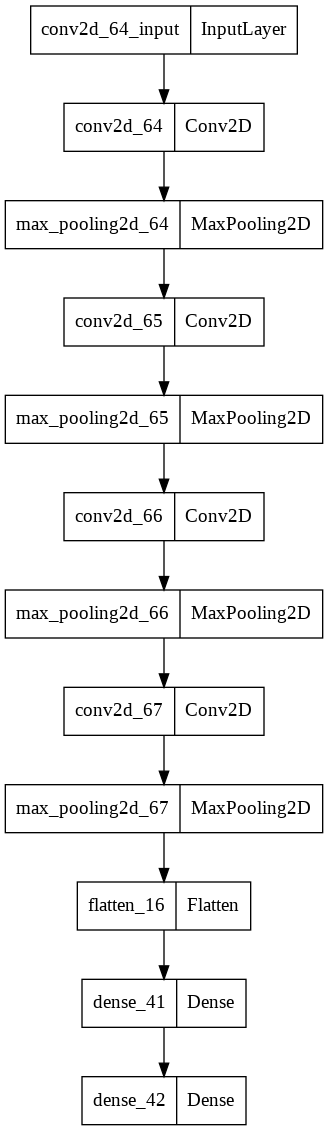

In [ ]:
plot_model(cnn_ib)

In [ ]:
cnn_ib.compile(optimizer='Adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [ ]:
history_ib=cnn_ib.fit(train_generator,
                          validation_data=valid_generator,
                          epochs=20, 
                          verbose=1,)

Epoch 1/20
421/421 [==============================] - 192s 454ms/step - loss: 1.9543 - accuracy: 0.4850 - val_loss: 1.0510 - val_accuracy: 0.8170
Epoch 2/20
421/421 [==============================] - 193s 458ms/step - loss: 1.1082 - accuracy: 0.7808 - val_loss: 0.7802 - val_accuracy: 0.8976
Epoch 3/20
421/421 [==============================] - 191s 455ms/step - loss: 0.9324 - accuracy: 0.8424 - val_loss: 0.6633 - val_accuracy: 0.9348
Epoch 4/20
421/421 [==============================] - 191s 453ms/step - loss: 0.8138 - accuracy: 0.8738 - val_loss: 0.6524 - val_accuracy: 0.9326
Epoch 5/20
421/421 [==============================] - 191s 453ms/step - loss: 0.7559 - accuracy: 0.8881 - val_loss: 0.5930 - val_accuracy: 0.9505
Epoch 6/20
421/421 [==============================] - 191s 454ms/step - loss: 0.7232 - accuracy: 0.9046 - val_loss: 0.6049 - val_accuracy: 0.9445
Epoch 7/20
421/421 [==============================] - 192s 456ms/step - loss: 0.6987 - accuracy: 0.9105 - val_loss: 0.5651 -

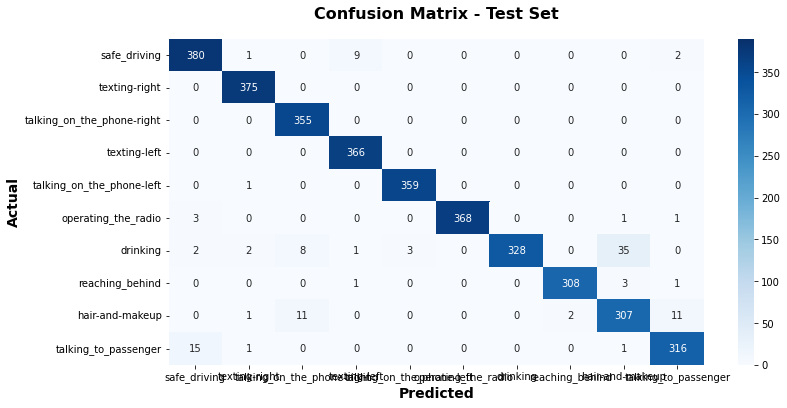

In [ ]:
#CategoricalAccuracy
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
classes = [
          "safe_driving",
          "texting-right",
          "talking_on_the_phone-right", 
          "texting-left", 
          "talking_on_the_phone-left",
          "operating_the_radio",
          "drinking",
          "reaching_behind",
          "hair-and-makeup",
          "talking_to_passenger"
          ]
y_pred = cnn_ib.predict(test_generator)
predictions = np.array(list(map(lambda x: np.argmax(x), y_pred)))

y_true=test_generator.classes

CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index =classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 390,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

In [ ]:
print(classification_report(y_true, predictions))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       392
           1       0.98      1.00      0.99       375
           2       0.95      1.00      0.97       355
           3       0.97      1.00      0.99       366
           4       0.99      1.00      0.99       360
           5       1.00      0.99      0.99       373
           6       1.00      0.87      0.93       379
           7       0.99      0.98      0.99       313
           8       0.88      0.92      0.90       332
           9       0.95      0.95      0.95       333

    accuracy                           0.97      3578
   macro avg       0.97      0.97      0.97      3578
weighted avg       0.97      0.97      0.97      3578



In [ ]:
history_ib=cnn_ib.fit(train_generator,
                          validation_data=valid_generator,
                          epochs=20, 
                          verbose=1,)

Epoch 1/20
421/421 [==============================] - 225s 532ms/step - loss: 2.2844 - accuracy: 0.1199 - val_loss: 1.8749 - val_accuracy: 0.3328
Epoch 2/20
421/421 [==============================] - 223s 529ms/step - loss: 1.7925 - accuracy: 0.3467 - val_loss: 1.1837 - val_accuracy: 0.5687
Epoch 3/20
421/421 [==============================] - 224s 533ms/step - loss: 1.2485 - accuracy: 0.5542 - val_loss: 0.6722 - val_accuracy: 0.7839
Epoch 4/20
421/421 [==============================] - 226s 536ms/step - loss: 0.8988 - accuracy: 0.6883 - val_loss: 0.4415 - val_accuracy: 0.8522
Epoch 5/20
421/421 [==============================] - 224s 533ms/step - loss: 0.7017 - accuracy: 0.7622 - val_loss: 0.3716 - val_accuracy: 0.8706
Epoch 6/20
421/421 [==============================] - 223s 529ms/step - loss: 0.5575 - accuracy: 0.8093 - val_loss: 0.2832 - val_accuracy: 0.9110
Epoch 7/20
421/421 [==============================] - 222s 527ms/step - loss: 0.4676 - accuracy: 0.8428 - val_loss: 0.2143 -

In [ ]:
cnn_ib.save('/content/drive/MyDrive/Dataset/model_IB.h5')

In [ ]:
test_loss, test_acc = cnn_ib.evaluate(test_generator)

112/112 [==============================] - 20s 175ms/step - loss: 0.1320 - accuracy: 0.9575


## **Performance Plot**

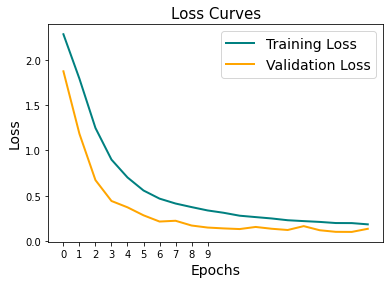

In [ ]:
# Loss curve
plt.figure(figsize=[6,4])
plt.plot(history_ib.history['loss'], 'teal', linewidth=2.0)
plt.plot(history_ib.history['val_loss'], 'orange', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.xticks(range(0,10))
plt.title('Loss Curves', fontsize=15)
plt.show()

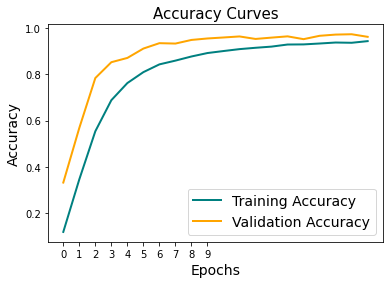

In [ ]:
# Accuracy curve
plt.figure(figsize=[6,4])
plt.plot(history_ib.history['accuracy'], 'teal', linewidth=2.0)
plt.plot(history_ib.history['val_accuracy'], 'orange', linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=14)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xticks(range(0,10))
plt.title('Accuracy Curves', fontsize=15)
plt.show()

## **Confusion Matrix**

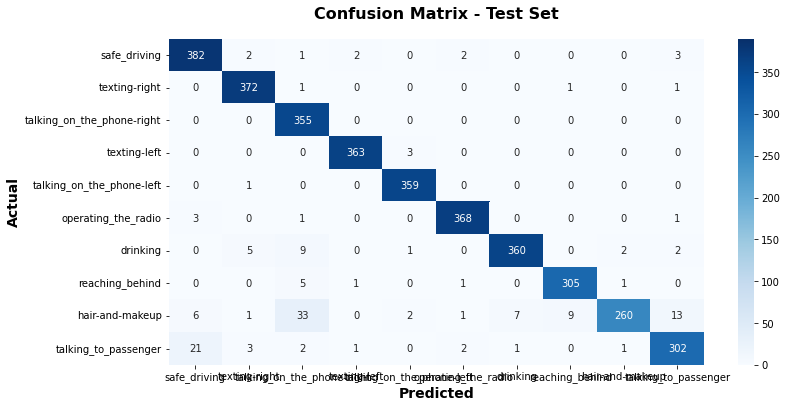

In [ ]:
#CategoricalAccuracy
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
classes = [
          "safe_driving",
          "texting-right",
          "talking_on_the_phone-right", 
          "texting-left", 
          "talking_on_the_phone-left",
          "operating_the_radio",
          "drinking",
          "reaching_behind",
          "hair-and-makeup",
          "talking_to_passenger"
          ]
y_pred = cnn_ib.predict(test_generator)
predictions = np.array(list(map(lambda x: np.argmax(x), y_pred)))

y_true=test_generator.classes

CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index =classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 390,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

In [ ]:
print(classification_report(y_true, predictions))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       392
           1       0.97      0.99      0.98       375
           2       0.87      1.00      0.93       355
           3       0.99      0.99      0.99       366
           4       0.98      1.00      0.99       360
           5       0.98      0.99      0.99       373
           6       0.98      0.95      0.96       379
           7       0.97      0.97      0.97       313
           8       0.98      0.78      0.87       332
           9       0.94      0.91      0.92       333

    accuracy                           0.96      3578
   macro avg       0.96      0.96      0.96      3578
weighted avg       0.96      0.96      0.96      3578



## **Data Testing**

Found 3578 images belonging to 10 classes.
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


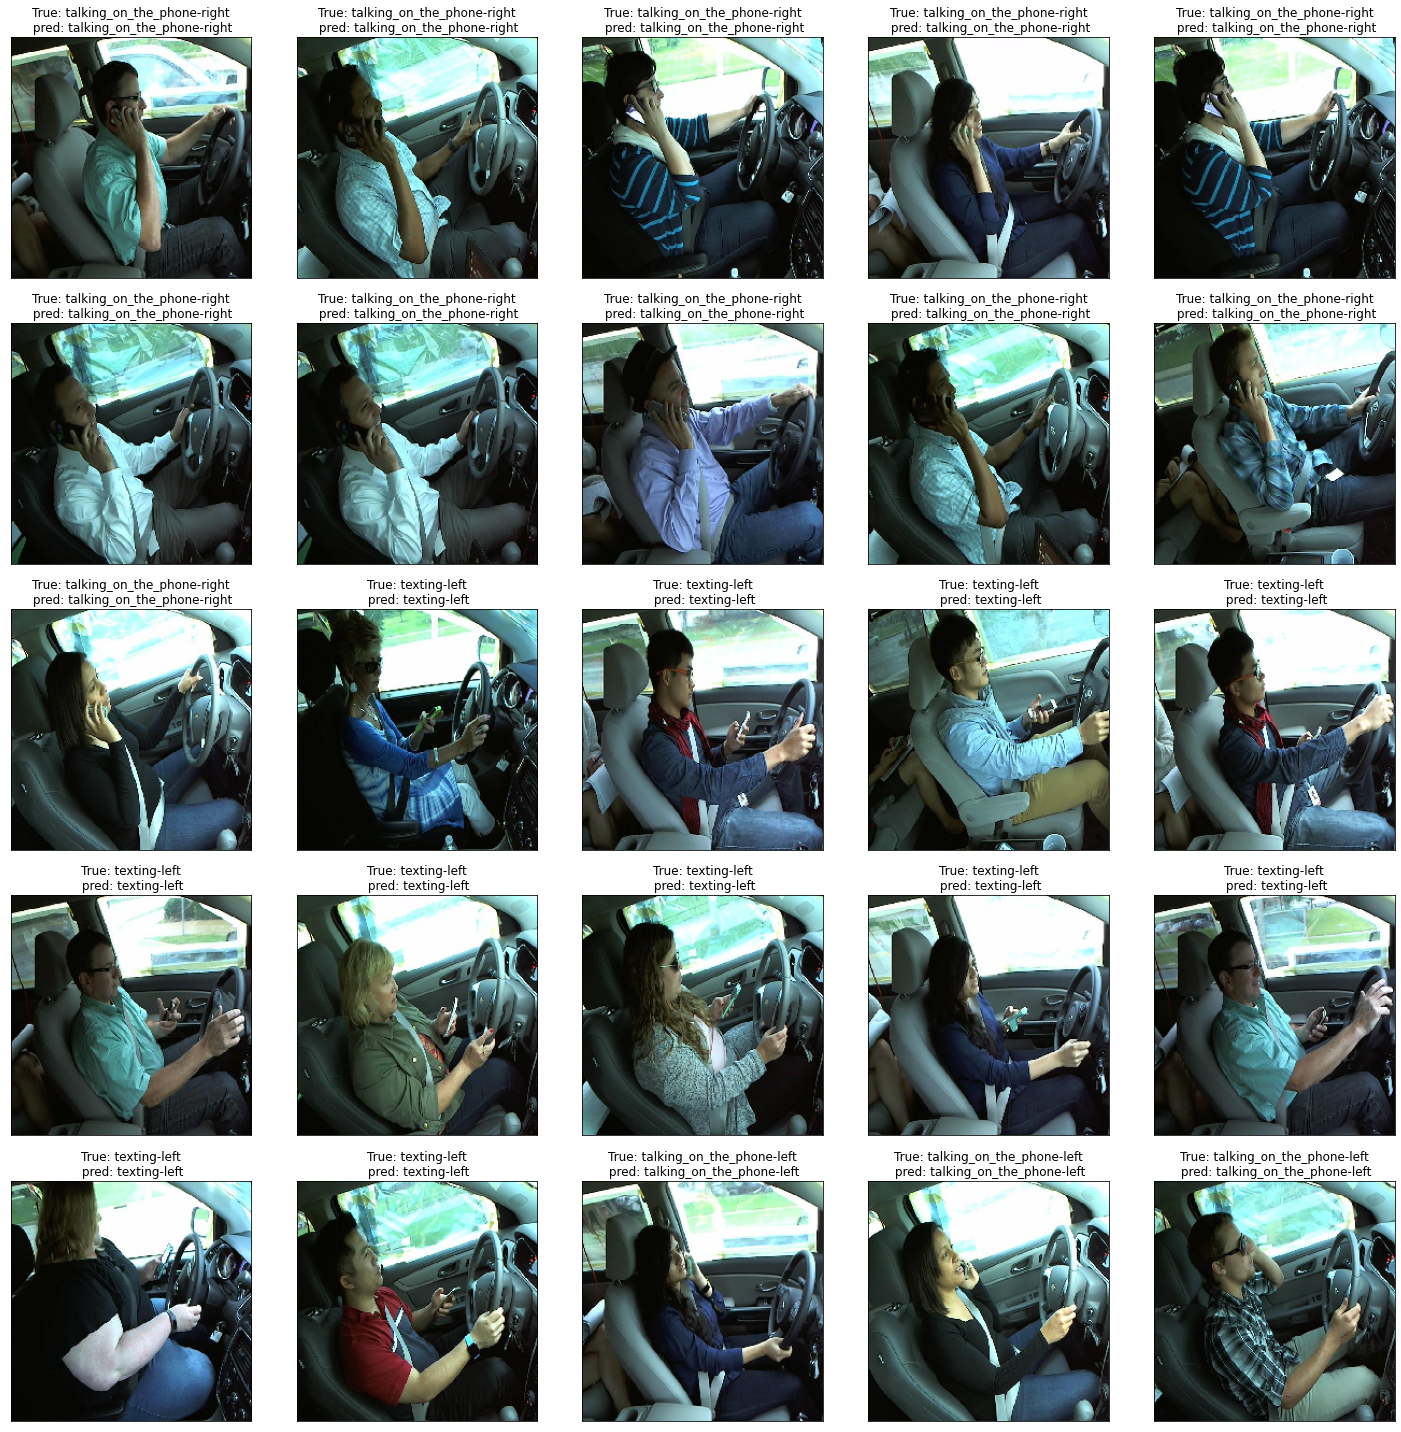

In [ ]:
test_data = test_datagen.flow_from_directory(test_path,target_size=(224, 224),class_mode="binary",shuffle=False)
plt.figure(figsize=(20, 20))
for i in range(0, 25):
    plt.subplot(5, 5, i+1)
    for X_batch, Y_batch in test_generator:
        print(Y_batch)
        image = X_batch[0]
        plt.imshow(image)
        x=np.array(image).reshape(1,224,224,3)
        pred=cnn_ib.predict(x)
        true_label=classes_name.get("c"+str(int(np.argmax(Y_batch[0]))))
        pred_label=classes_name.get("c"+str(int(np.argmax(pred))))
        plt.yticks([])
        plt.xticks([])
        plt.title(f"True: {true_label}\n pred: {pred_label}")
        break
plt.tight_layout()
plt.show()